<a href="https://colab.research.google.com/github/teddy4445/bpd_socio_demographic/blob/main/amit_rosenfeld_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stracture of the notebook

1.   Organize the data into something we can work with
2.   EDA 
3.   Spesific analysis for the paper 
4.   Ploting figures for the paper


Add needed installs to the notepad 

In [ ]:
!pip install TPOT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11938 sha256=8c8058c77f9a031601031681c97470453a28eb284e9df9da792f273c76ef7a80
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


Start with all the imports so it will be easy to run each time loading the notebook

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import export_text
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from tpot import TPOTRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr

As part of the manual process of organizing the data, I (Teddy) changed the strings into values, encoding as I see fit. So we can easy recall the origianl text, I put it in the next dict.

In [ ]:
values_dict = {
	"is_new": {"no": 0, "yes": 1},
	"home_people": {"alone": 0, "partner": 1, "parents": 2, "family": 3, "roomamtes": 4},
	"is_working": {"no": 0, "partial": 1, "yes": 2},
	"education": {"full bagrut": 2, "partial bagrut": 1, "no bagrut": 0, "academic": 3},
	"family_status": {"single": 0, "married": 1, "div": 2},
	"is_first_time": {"no": 0, "yes": 1},
  "gender": {"male": 0, "female": 1}
}

Now, we need to remove undeed rows in the CSV and afterwards copies based on visits in the same time - not sure why there are to begin with

In [ ]:
visits_df = pd.read_csv("data2.csv")
visits_df = visits_df[~np.isnan(visits_df["p_index"])]
visits_df = visits_df.drop_duplicates(subset=['issue_date',"p_index"], keep="first")
visits_df['issue_date'] = pd.to_datetime(visits_df['issue_date'])
visits_df.reset_index(inplace=True, drop=True)
for col in ["current_age", "gender", "is_new", "stay_duration", "age", "education", "family_status"]:
  visits_df[col] = pd.to_numeric(visits_df[col], errors='coerce')

<ipython-input-40-7eb096c9482e>:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  visits_df['issue_date'] = pd.to_datetime(visits_df['issue_date'])


Organize DataFrame of per individual so it will be easy to test properties on the individual level rather than the visit level

In [ ]:
individuals_df = visits_df.groupby(["p_index"])
for name, group in individuals_df:
  group.sort_values(by=["issue_date"], inplace=True)

<ipython-input-6-14c4cf989f30>:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in individuals_df:


### Useful functions

In [ ]:
def print_df_to_file(dt,
                     feature_names,   
                     file_path):
  r = export_text(dt, 
                  feature_names=feature_names)
  with open(file_path, "w") as dt_file:
    dt_file.write(r)
  

## Post-mortom analysis

In [ ]:
visits_df.head()

,p_index,current_age,gender,issue_date,stay_duration,is_new,age,education,family_status,kids,...,try_self_harm,try_suaside,natoral_insurance,suaside_during_visit,bad_thoughts_during_visit,using_drags,using_alcohol,self_harm_during_visit2,self_kill_during_visit,Fak
0,1.0,72,1.0,2002-06-17,15.0,0,52,NaN,0.0,0.0,...,0.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0
1,1.0,72,1.0,2005-01-29,9.0,0,55,NaN,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,72,1.0,2005-02-14,6.0,0,55,NaN,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,72,1.0,2006-05-31,1.0,0,56,NaN,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,72,1.0,2007-07-09,2.0,0,57,NaN,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
list(visits_df.head())

['p_index',
 'current_age',
 'gender',
 'issue_date',
 'stay_duration',
 'is_new',
 'age',
 'education',
 'family_status',
 'kids',
 'is_working',
 'home_people',
 'treatment',
 'try_self_harm',
 'try_suaside',
 'natoral_insurance',
 'suaside_during_visit',
 'bad_thoughts_during_visit',
 'using_drags',
 'using_alcohol',
 'self_harm_during_visit2',
 'self_kill_during_visit',
 'Fak']

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

new_col = []
visit_index = 1
this_p_index = 1
for row_index, row in visits_df.iterrows():
  if this_p_index != int(row["p_index"]):
    new_col.append(1)
    visit_index = 2
    this_p_index = int(row["p_index"])
  else:
    new_col.append(visit_index)
    visit_index += 1
visits_df["visit_index"] = new_col


linear_visits_df = visits_df.drop(["p_index", "issue_date", "treatment", "Fak",
                                   "try_self_harm", "try_suaside", "natoral_insurance",
                                   "suaside_during_visit", "bad_thoughts_during_visit", "using_drags",
                                   "using_alcohol", "self_harm_during_visit2", "self_kill_during_visit", "is_new"], axis=1)
linear_visits_df["kids"] = linear_visits_df["kids"].apply(lambda x: 1 if x > 0.5 else 0)
linear_visits_df.dropna(inplace=True)

In [ ]:
linear_visits_df.head(10)

,current_age,gender,stay_duration,is_new,age,education,family_status,kids,is_working,home_people,visit_index
17,33,1.0,158.0,1,23,2.0,0.0,0,0.0,2.0,1
26,55,1.0,9.0,1,53,1.0,2.0,1,0.0,0.0,1
29,54,1.0,2.0,1,44,0.0,0.0,0,2.0,0.0,1
30,54,1.0,7.0,0,45,0.0,0.0,0,2.0,0.0,2
31,53,1.0,204.0,1,49,2.0,2.0,1,0.0,0.0,1
51,52,1.0,7.0,1,52,2.0,2.0,1,0.0,0.0,1
52,52,1.0,5.0,1,50,1.0,2.0,0,0.0,0.0,1
56,52,1.0,19.0,0,37,2.0,0.0,0,2.0,0.0,4
57,52,1.0,14.0,0,37,2.0,0.0,0,2.0,0.0,5
58,52,1.0,67.0,0,38,2.0,0.0,0,2.0,0.0,6


In [ ]:
linear_visits_df = pd.get_dummies(linear_visits_df, columns=['education', 'family_status', 'is_working', 'home_people'], prefix_sep='_')

In [ ]:
linear_visits_df.head(10)

,current_age,gender,stay_duration,age,kids,visit_index,education_0.0,education_1.0,education_2.0,education_3.0,...,family_status_1.0,family_status_2.0,is_working_0.0,is_working_1.0,is_working_2.0,home_people_0.0,home_people_1.0,home_people_2.0,home_people_3.0,home_people_4.0
17,33,1.0,158.0,23,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
26,55,1.0,9.0,53,1,1,0,1,0,0,...,0,1,1,0,0,1,0,0,0,0
29,54,1.0,2.0,44,0,1,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0
30,54,1.0,7.0,45,0,2,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0
31,53,1.0,204.0,49,1,1,0,0,1,0,...,0,1,1,0,0,1,0,0,0,0
51,52,1.0,7.0,52,1,1,0,0,1,0,...,0,1,1,0,0,1,0,0,0,0
52,52,1.0,5.0,50,0,1,0,1,0,0,...,0,1,1,0,0,1,0,0,0,0
56,52,1.0,19.0,37,0,4,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
57,52,1.0,14.0,37,0,5,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
58,52,1.0,67.0,38,0,6,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0


In [ ]:
X = linear_visits_df.drop(["stay_duration"], axis=1)
y = linear_visits_df["stay_duration"]

reg = LinearRegression().fit(X, y)
print("x,y - score {}".format(reg.score(X, y)))
print("duration = {} + {:.2f}".format(" + ".join(["{:.2f} {}".format(reg.coef_[index], list(X)[index]) for index in range(len(reg.coef_))]), reg.intercept_))
print("R^2 = {:.3f}".format(r2_score(y, reg.predict(X))))


x,y - score 0.08438127479023627
duration = -0.99 current_age + 25.51 gender + 0.06 age + 14.54 kids + -1.15 visit_index + 13.06 education_0.0 + -13.16 education_1.0 + 5.67 education_2.0 + -5.57 education_3.0 + 11.70 family_status_0.0 + -1.06 family_status_1.0 + -10.64 family_status_2.0 + 16.45 is_working_0.0 + -17.22 is_working_1.0 + 0.77 is_working_2.0 + -13.24 home_people_0.0 + -23.71 home_people_1.0 + 77.96 home_people_2.0 + -10.59 home_people_3.0 + -30.41 home_people_4.0 + 53.28
R^2 = 0.084


In [ ]:
import statsmodels.api as sm
mod = sm.OLS(y,X)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
print(p_values)

current_age          0.197434
gender               0.000734
age                  0.931812
kids                 0.154322
visit_index          0.003989
education_0.0        0.000772
education_1.0        0.865701
education_2.0        0.023186
education_3.0        0.401602
family_status_0.0    0.002215
family_status_1.0    0.161756
family_status_2.0    0.549323
is_working_0.0       0.000080
is_working_1.0       0.906826
is_working_2.0       0.062246
home_people_0.0      0.741303
home_people_1.0      0.345740
home_people_2.0      0.011353
home_people_3.0      0.917957
home_people_4.0      0.418651
Name: P>|t|, dtype: float64


In [ ]:
# We need to understand how we calcuate the time to next 
visits_df = pd.read_csv("data2.csv")
visits_df = visits_df[~np.isnan(visits_df["p_index"])]
visits_df = visits_df.drop_duplicates(subset=['issue_date','p_index'], keep="first")
visits_df['issue_date'] = pd.to_datetime(visits_df['issue_date'])
visits_df.reset_index(inplace=True, drop=True)
for col in ["current_age", "gender", "is_new", "stay_duration", "age", "education", "family_status"]:
  visits_df[col] = pd.to_numeric(visits_df[col], errors='coerce')

individuals_df = visits_df.groupby(["p_index"])
for name, group in individuals_df:
  group.sort_values(by=["issue_date"], inplace=True)

print("individuals_df size is {}".format(len(individuals_df)))
individuals_df = [group for name, group in individuals_df if group.shape[0] > 1]
print("individuals_df size is {} after removing one-visiters".format(len(individuals_df)))

issue_date_col_index = 3

for group in individuals_df:
  new_col = [None]
  for row_index in range(1, len(group)):
    new_col.append((group.iloc[row_index, issue_date_col_index] - group.iloc[row_index-1, issue_date_col_index]).days)
  group["next_time_visit"] = new_col
  group.dropna(inplace=True)

print("individuals_df size after removing nans and preparing data - {}".format(len(individuals_df)))
individuals_df = [group for group in individuals_df if group.shape[0] > 1]
print("individuals_df size after removing empty individual sets - {}".format(len(individuals_df)))

<ipython-input-53-837643949489>:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  visits_df['issue_date'] = pd.to_datetime(visits_df['issue_date'])
<ipython-input-53-837643949489>:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in individuals_df:
<ipython-input-53-837643949489>:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  individuals_df = [group for name, group in individuals_df if group.shape[0] > 1]


individuals_df size is 200
individuals_df size is 129 after removing one-visiters
individuals_df size after removing nans and preparing data - 129
individuals_df size after removing empty individual sets - 56


In [ ]:
visits_again = pd.concat(individuals_df)
visits_again.head()

,p_index,current_age,gender,issue_date,stay_duration,is_new,age,education,family_status,kids,...,try_suaside,natoral_insurance,suaside_during_visit,bad_thoughts_during_visit,using_drags,using_alcohol,self_harm_during_visit2,self_kill_during_visit,Fak,next_time_visit
56,17.0,52,1.0,2007-03-14,19.0,0,37,2.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1493.0
57,17.0,52,1.0,2007-07-19,14.0,0,37,2.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,127.0
58,17.0,52,1.0,2008-09-02,67.0,0,38,2.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,411.0
59,17.0,52,1.0,2008-09-24,98.0,0,38,2.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,22.0
60,17.0,52,1.0,2009-03-06,2.0,0,39,2.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,163.0


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm

new_col = []
visit_index = 1
this_p_index = 1
for row_index, row in visits_again.iterrows():
  if this_p_index != int(row["p_index"]):
    new_col.append(1)
    visit_index = 2
    this_p_index = int(row["p_index"])
  else:
    new_col.append(visit_index)
    visit_index += 1
visits_again["visit_index"] = new_col


linear_visits_df = visits_again.drop(["p_index", "issue_date", "treatment", "Fak",
                                   "try_self_harm", "try_suaside", "natoral_insurance",
                                   "suaside_during_visit", "bad_thoughts_during_visit", "using_drags",
                                   "using_alcohol", "self_harm_during_visit2", "self_kill_during_visit", "is_new"], axis=1)
linear_visits_df["kids"] = linear_visits_df["kids"].apply(lambda x: 1 if x > 0.5 else 0)
linear_visits_df.dropna(inplace=True)

linear_visits_df = pd.get_dummies(linear_visits_df, columns=['education', 'family_status', 'is_working', 'home_people'], prefix_sep='_')

X = linear_visits_df.drop(["next_time_visit"], axis=1)
y = linear_visits_df["next_time_visit"]

reg = LinearRegression().fit(X, y)
print("x,y - score {}".format(reg.score(X, y)))
print("next_visit = {} + {:.2f}".format(" + ".join(["{:.2f} {}".format(reg.coef_[index], list(X)[index]) for index in range(len(reg.coef_))]), reg.intercept_))
print("R^2 = {:.3f}".format(r2_score(y, reg.predict(X))))

mod = sm.OLS(y,X)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
print(p_values)

x,y - score 0.1756025619857714
next_visit = -29.04 current_age + 46.05 gender + -0.24 stay_duration + 34.63 age + 18.30 kids + -30.33 visit_index + 114.88 education_0.0 + -188.24 education_1.0 + 185.48 education_2.0 + -112.13 education_3.0 + -131.38 family_status_0.0 + 403.83 family_status_1.0 + -272.46 family_status_2.0 + 27.07 is_working_0.0 + -48.70 is_working_1.0 + 21.63 is_working_2.0 + -317.07 home_people_0.0 + 551.67 home_people_1.0 + -234.60 home_people_3.0 + 952.54
R^2 = 0.176
current_age          0.033867
gender               0.692493
stay_duration        0.716519
age                  0.001094
kids                 0.911304
visit_index          0.000019
education_0.0        0.007651
education_1.0        0.980879
education_2.0        0.003056
education_3.0        0.468631
family_status_0.0    0.371080
family_status_1.0    0.000178
family_status_2.0    0.880153
is_working_0.0       0.019614
is_working_1.0       0.161169
is_working_2.0       0.034140
home_people_0.0      0.672261

## EDA part

Get some general stats

In [ ]:
visits_counts = individuals_df["gender"].count()
print("We have {} visits from {} individuals with {} properties for each visit".format(visits_df.shape[0], 
                                                                                       visits_counts.shape[0],
                                                                                       visits_df.shape[1]-1))
print("An individual  has {:.2f} +- {:.2f} visits".format(np.mean(visits_counts),
                                                            np.std(visits_counts)))

females_count = sum([1 if val > 0 else 0 for val in individuals_df["gender"].sum()])
print("There are {} ({:.2f}%) female and {} ({:.2f}%) male".format(females_count,
                                                                  100*females_count/visits_counts.shape[0],
                                                                  visits_counts.shape[0] - females_count,
                                                                  100*(visits_counts.shape[0] - females_count)/visits_counts.shape[0]))

We have 1077 visits from 200 individuals with 22 properties for each visit
An individual  has 5.36 +- 7.20 visits
There are 169 (84.50%) female and 31 (15.50%) male


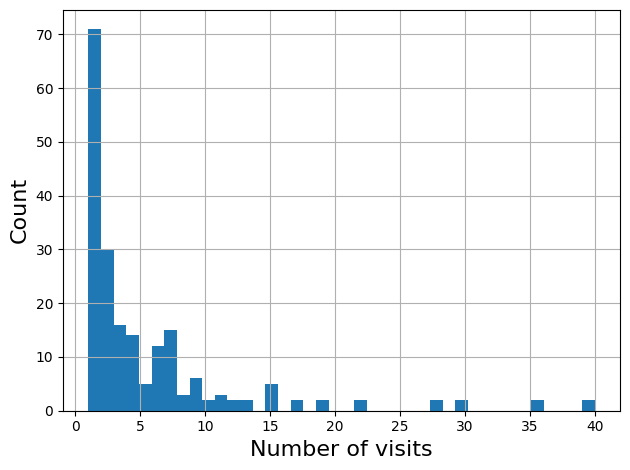

In [ ]:
# just learn a bit the distributions of properties
individuals_df["current_age"].count().hist(bins=40)
plt.xlabel("Number of visits", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.tight_layout()
plt.savefig("visits_hist.png", dpi=300)
plt.show()
plt.close()

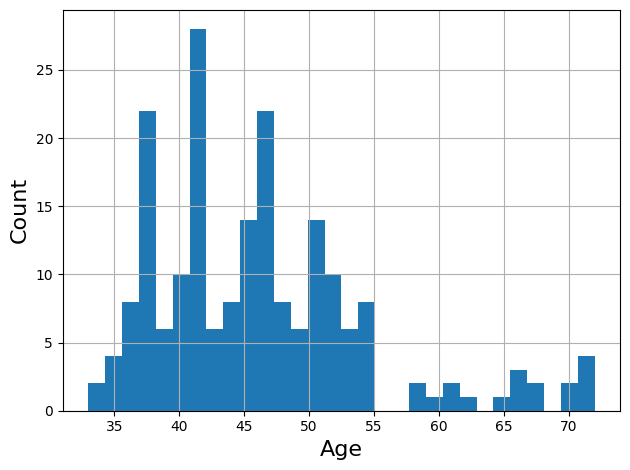

In [ ]:
# just learn a bit the distributions of properties
individuals_df["current_age"].mean().hist(bins=30)
plt.xlabel("Age", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.tight_layout()
plt.savefig("current_age_hist.png", dpi=300)
plt.show()
plt.close()

Now, we repeat for the general case - reporting mean +- std and showing the historgram

In [ ]:
for col in list(visits_df):
  try:
    a = visits_df.dropna(subset=[col])
    a = list(a[col])
    print("{}: {:.3f} +- {:.3f}".format(col, np.mean(visits_df[col]), np.std(visits_df[col])))
    if len(set(a)) < 8:
      u_vals = set(a)
      for u_val in u_vals:
        print("{} -> {:.3f}%".format(u_val, 100*len([True for val in a if val == u_val])/len(a))) 
      print("\n\n")
    else:
      print("\n")
  except:
    pass

p_index: 107.957 +- 57.527


current_age: 45.208 +- 8.153


gender: 0.798 +- 0.401
0.0 -> 20.168%
1.0 -> 79.832%



stay_duration: 30.507 +- 68.620


is_new: 0.159 +- 0.365
0 -> 84.123%
1 -> 15.877%



age: 36.833 +- 9.587


education: 1.350 +- 1.115
0.0 -> 32.267%
1.0 -> 18.895%
2.0 -> 30.378%
3.0 -> 18.459%



family_status: 0.641 +- 0.855
0.0 -> 61.015%
1.0 -> 13.909%
2.0 -> 25.076%



kids: 0.963 +- 1.520


is_working: 0.569 +- 0.881
0.0 -> 69.717%
1.0 -> 3.704%
2.0 -> 26.580%



home_people: 2.026 +- 1.449
0.0 -> 29.261%
1.0 -> 8.111%
2.0 -> 1.232%
3.0 -> 53.593%
4.0 -> 7.803%



try_self_harm: 0.530 +- 0.499
0.0 -> 47.018%
1.0 -> 52.982%



try_suaside: 0.815 +- 0.388
0.0 -> 18.478%
1.0 -> 81.522%



natoral_insurance: 0.693 +- 0.461
0.0 -> 30.661%
1.0 -> 69.339%



suaside_during_visit: 0.140 +- 0.347
0.0 -> 85.956%
1.0 -> 14.044%



bad_thoughts_during_visit: 0.660 +- 0.474
0.0 -> 33.964%
1.0 -> 66.036%



using_drags: 0.083 +- 0.275
0.0 -> 91.733%
1.0 -> 8.267%



using_alcoho

<ipython-input-10-006db9fa44f2>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sns.heatmap(individuals_df["stay_duration", "age", 'education', 'family_status', 'kids', 'is_working', 'try_self_harm', 'try_suaside', 'using_drags', 'using_alcohol'].mean().corr(),


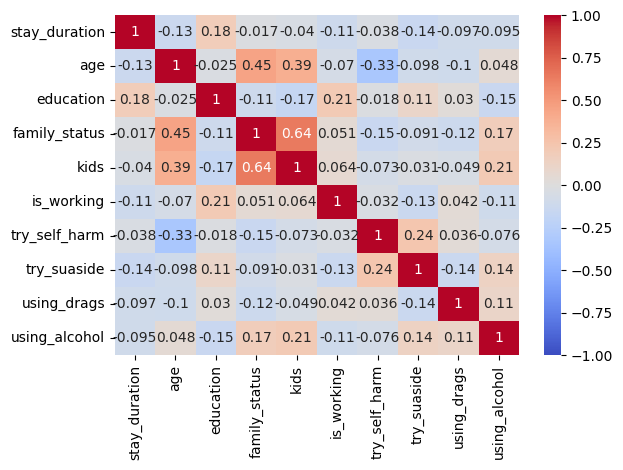

In [ ]:
sns.heatmap(individuals_df["stay_duration", "age", 'education', 'family_status', 'kids', 'is_working', 'try_self_harm', 'try_suaside', 'using_drags', 'using_alcohol'].mean().corr(),
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            annot=True)
plt.tight_layout()
plt.savefig("pearson_heatmap.png", dpi=300)
plt.show()
plt.close()

In [ ]:
#sns.pairplot(individuals_df.mean())
#plt.tight_layout()
#plt.savefig("pairplot.png", dpi=300)
#plt.show()
#plt.close()

## Main Research Questions

1. What are the socio-demographic properties responsible to predict the duration of a stay?
2. Does the historical data about previous stays helps to predict the next one?
3. Does the combination of 1+2 provide improvments?
4. Repeat 1 to 3 but with next addministration rather than stay duration

In [ ]:
# just so it will be easy to see the features' names
print(list(visits_df))

['p_index', 'current_age', 'gender', 'issue_date', 'stay_duration', 'is_new', 'age', 'education', 'family_status', 'kids', 'is_working', 'home_people', 'treatment', 'try_self_harm', 'try_suaside', 'natoral_insurance', 'suaside_during_visit', 'bad_thoughts_during_visit', 'using_drags', 'using_alcohol', 'self_harm_during_visit2', 'self_kill_during_visit', 'Fak']


Check how the dynamic in the population changes as the number of visits

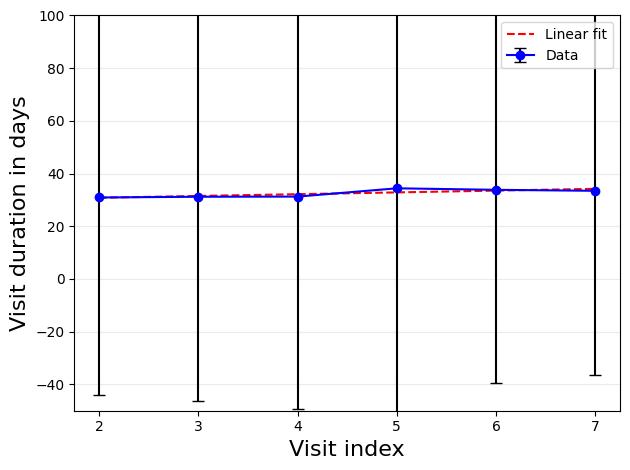

visit duration = 0.677 * visit index + 29.473 | R^2 = 0.668
Samples per previous visits count: [724, 627, 546, 479, 417, 369]
Individauls per previous visits count: [99, 83, 69, 64, 52, 37]


In [ ]:
# try to find a connection between staying durations in the individaul level
individuals_df = visits_df.groupby(["p_index"])
stay_per_individaul = [list(list(ind_list)[1]) for ind_list in individuals_df["stay_duration"]]
tail_lens = list(range(2, 8))

sample_count = []
ind_count = []
means = []
stds = []

for tail_len in tail_lens:
  rows = []
  this_ind_count = 0
  for stay_per_individaul_list in stay_per_individaul:
    if len(stay_per_individaul_list) > tail_len:
      this_ind_count += 1
      for index in range(tail_len, len(stay_per_individaul_list)):
        rows.append([stay_per_individaul_list[index - tail_index] for tail_index in range(tail_len+1)])
  ind_count.append(this_ind_count)
  columns = ["p_visit_{}".format(tail_len - tail_index) for tail_index in range(tail_len)]
  columns.append("this_visit")
  visits_stay_duration_df = pd.DataFrame(rows,
                                        columns=columns) 
  # should not happen but just in case
  visits_stay_duration_df.dropna(inplace=True)
  means.append(np.mean(visits_stay_duration_df["this_visit"]))
  stds.append(np.std(visits_stay_duration_df["this_visit"])) 
  sample_count.append(visits_stay_duration_df.shape[0])

# print results 
plt.errorbar(x=tail_lens,
             y=means,
             yerr=stds,
             marker="o",
             capsize=4,
             ecolor="black",
             color="blue",
             label="Data")

lg = LinearRegression()
lg.fit([[val] for val in tail_lens],
       means)
plt.plot([2, 7],
         [lg.predict([[2]])[0], lg.predict([[7]])[0]],
         "--",
         color="red",
         label="Linear fit")

plt.xlabel("Visit index", fontsize=16)
plt.ylabel("Visit duration in days", fontsize=16)
plt.ylim((-50, 100))
plt.xticks(tail_lens)
plt.grid(alpha=0.25,
         axis="y")
plt.legend()
plt.tight_layout()
plt.savefig("time_series.png", dpi=300)
plt.show()
plt.close()
print("visit duration = {:.3f} * visit index + {:.3f} | R^2 = {:.3f}".format(lg.coef_[0], lg.intercept_, r2_score(means, lg.predict([[val] for val in tail_lens]))))
print("Samples per previous visits count: {}".format(sample_count))
print("Individauls per previous visits count: {}".format(ind_count))

### More exploration analysis

Visit index does not have infalunce on the visit duration

cross-individuals = 54.545%
   index  stay
0    0.0  15.0
1    1.0   9.0
2    2.0   6.0
3    3.0   1.0
4    4.0   2.0
Person: PearsonRResult(statistic=-0.06977997124028507, pvalue=0.028449817097500593)
Spearman: SignificanceResult(statistic=-0.09593155645305523, pvalue=0.0025660003232483254)


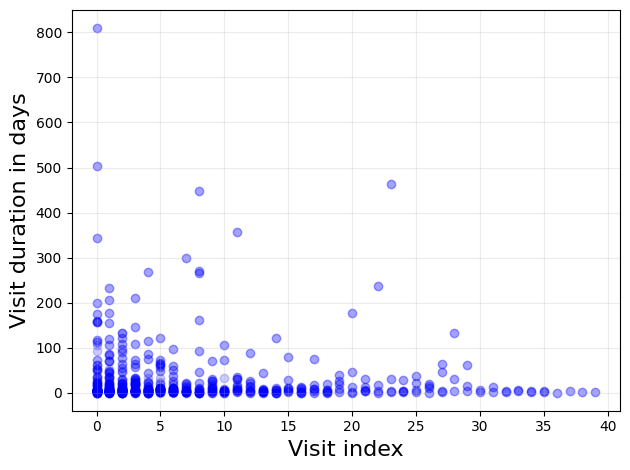

'\nfor visit_index in range(11):\n  this_df = df[df["index"] == visit_index]\n  this_df["stay"].hist(bins=20)\n  plt.xlabel("Stay duration")\n  plt.ylabel("Count")\n  plt.title("Visit index = {}".format(visit_index+1))\n  plt.show()\n  plt.close()\n'

In [ ]:
# try to find a connection between staying durations in the individaul level
individuals_df = visits_df.groupby(["p_index"])
stay_per_individaul = [list(list(ind_list)[1]) for ind_list in individuals_df["stay_duration"]]

index = []
stay_duration = []
tested_crosser = 0
problematic_crosser = 0

for stay_per_individaul_list in stay_per_individaul:
  if len(stay_per_individaul_list) > 1:
    for i in range(len(stay_per_individaul_list)):
      index.append(i)
      stay_duration.append(stay_per_individaul_list[i])
    
  if len(stay_per_individaul_list) > 2:
    if any([val > 40 for val in stay_per_individaul_list[1:]]) and any([val < 40 for val in stay_per_individaul_list[1:]]):
      problematic_crosser += 1
    tested_crosser += 1
print("cross-individuals = {:.3f}%".format(100*problematic_crosser/tested_crosser))

df = pd.DataFrame(np.array([index, stay_duration]).transpose(),
                  columns=["index", "stay"])
print(df.head())
df.dropna(inplace=True)

print("Person: {}".format(pearsonr(df.iloc[:, 0], df.iloc[:, 1])))
print("Spearman: {}".format(spearmanr(df.iloc[:, 0], df.iloc[:, 1])))

# print results 
plt.scatter(df["index"],
            df["stay"],
             marker="o",
             color="blue",
            alpha=0.2)
plt.xlabel("Visit index", fontsize=16)
plt.ylabel("Visit duration in days", fontsize=16)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("index_vs_visit_duration.png", dpi=300)
plt.show()
plt.close()

# ----------------------------------- # 

"""
for visit_index in range(11):
  this_df = df[df["index"] == visit_index]
  this_df["stay"].hist(bins=20)
  plt.xlabel("Stay duration")
  plt.ylabel("Count")
  plt.title("Visit index = {}".format(visit_index+1))
  plt.show()
  plt.close()
"""




Next question

In [ ]:
from scipy import stats
#from bioinfokit.analys import stat

In [ ]:
def print_differances(df, col):
  this_df = df.dropna()
  u_vals = list(set(this_df[col]))
  print("unqiue values = {}".format(u_vals))
  
  for u_val in u_vals:
    df_cut = this_df[this_df[col] == u_val]['stay_duration']
    print("{} -> {:.3f} +- {:.3f} | count = {},".format(u_val, np.mean(df_cut), np.std(df_cut), len(df_cut)), end=" ")
  
  if len(u_vals) == 2:
    ans_val = stats.ttest_ind(this_df[this_df[col] == u_vals[0]]['stay_duration'],
                          this_df[this_df[col] == u_vals[1]]['stay_duration'])
    print("\nStatistical test - {}".format(ans_val))
  else:
    a = [this_df[this_df[col] == u_val]['stay_duration'] for u_val in u_vals]
    fvalue, pvalue = stats.f_oneway(*a)
    ans_val = "fvalue = {:.3f} with pvalue = {:.3f}".format(fvalue, pvalue)
    print("\nStatistical test - {}".format(ans_val))

    t_test_matrix = []
    for i_index, i_list in enumerate(a):
      row = []
      for j_index, j_list in enumerate(a):
        row.append(stats.ttest_ind(i_list, j_list)[1])
      t_test_matrix.append(row)
    pd.DataFrame(data=t_test_matrix,
                 index=u_vals,
                 columns=u_vals).to_csv("t_test_matrix_{}.csv".format(col),
                                        index=False)

    """
    res = stat()
    res.tukey_hsd(df=df, res_var='value', xfac_var='treatments', anova_model='value ~ C(treatments)')
    res.tukey_summary
    """

In [ ]:
print("Gender")
print_differances(visits_df, 'gender')

Gender
unqiue values = [0.0, 1.0]
0.0 -> 20.346 +- 47.150 | count = 136, 1.0 -> 34.675 +- 61.522 | count = 424, 
Statistical test - Ttest_indResult(statistic=-2.4871013484576823, pvalue=0.013169966559949316)


In [ ]:
visits_df_edu = visits_df.dropna(subset=["education"])
print("Education")
print_differances(visits_df, 'education')

Education
unqiue values = [0.0, 1.0, 2.0, 3.0]
0.0 -> 27.459 +- 47.534 | count = 181, 1.0 -> 25.639 +- 63.909 | count = 122, 2.0 -> 39.226 +- 64.378 | count = 159, 3.0 -> 31.980 +- 59.376 | count = 98, 
Statistical test - fvalue = 1.610 with pvalue = 0.186


In [ ]:
import math
print("Age")
age_visits_df = visits_df.copy()
age_visits_df["age_group"] = age_visits_df["age"].apply(lambda x: (1+math.floor((x/10))))
print_differances(age_visits_df, 'age_group')

Age
unqiue values = [2, 3, 4, 5, 6, 7]
2 -> 193.000 +- 107.000 | count = 4, 3 -> 30.482 +- 47.887 | count = 85, 4 -> 27.844 +- 53.680 | count = 289, 5 -> 36.930 +- 67.811 | count = 158, 6 -> 7.667 +- 5.995 | count = 21, 7 -> 21.000 +- 28.284 | count = 3, 
Statistical test - fvalue = 7.690 with pvalue = 0.000


In [ ]:
visits_df_edu = visits_df.dropna(subset=["family_status"])
print("family_status")
print_differances(visits_df, 'family_status')

family_status
unqiue values = [0.0, 1.0, 2.0]
0.0 -> 33.673 +- 65.594 | count = 361, 1.0 -> 29.732 +- 49.751 | count = 56, 2.0 -> 25.510 +- 40.065 | count = 143, 
Statistical test - fvalue = 1.009 with pvalue = 0.365


In [ ]:
visits_df_kids = visits_df.dropna(subset=["kids"])
visits_df_kids["has_kids"] = visits_df_kids["kids"].apply(lambda x: x > 0)
print("Has kids")
print_differances(visits_df_kids, 'has_kids')

Has kids
unqiue values = [False, True]
False -> 32.681 +- 64.090 | count = 376, True -> 28.158 +- 45.526 | count = 184, 
Statistical test - Ttest_indResult(statistic=0.8557967326460955, pvalue=0.39247754957969083)


<ipython-input-21-0be9c8d5d781>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visits_df_kids["has_kids"] = visits_df_kids["kids"].apply(lambda x: x > 0)


In [ ]:
visits_df_work = visits_df.dropna(subset=["is_working"])
print("is_working")
print_differances(visits_df_work, 'is_working')

is_working
unqiue values = [0.0, 1.0, 2.0]
0.0 -> 36.074 +- 68.440 | count = 366, 1.0 -> 9.000 +- 13.879 | count = 26, 2.0 -> 24.000 +- 32.619 | count = 168, 
Statistical test - fvalue = 4.434 with pvalue = 0.012


In [ ]:
visits_df_work = visits_df.dropna(subset=["home_people"])
print("home_people")
print_differances(visits_df_work, 'home_people')

home_people
unqiue values = [0.0, 1.0, 2.0, 3.0, 4.0]
0.0 -> 29.284 +- 42.718 | count = 176, 1.0 -> 17.700 +- 16.414 | count = 20, 2.0 -> 158.000 +- 0.000 | count = 2, 3.0 -> 32.388 +- 66.081 | count = 358, 4.0 -> 12.500 +- 5.500 | count = 4, 
Statistical test - fvalue = 2.816 with pvalue = 0.025


<ipython-input-16-c2ccf253ebb9>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  row.append(stats.ttest_ind(i_list, j_list)[1])


In [ ]:
visits_df_work = visits_df.dropna(subset=["using_drags"])
print("using_drags")
print_differances(visits_df_work, 'using_drags')

using_drags
unqiue values = [0.0, 1.0]
0.0 -> 32.545 +- 60.627 | count = 519, 1.0 -> 14.098 +- 13.766 | count = 41, 
Statistical test - Ttest_indResult(statistic=1.9409416786772122, pvalue=0.052768553971607776)


In [ ]:
visits_df_work = visits_df.dropna(subset=["using_alcohol"])
print("using_alcohol")
print_differances(visits_df_work, 'using_alcohol')

using_alcohol
unqiue values = [0.0, 1.0]
0.0 -> 31.638 +- 59.106 | count = 550, 1.0 -> 6.800 +- 8.942 | count = 10, 
Statistical test - Ttest_indResult(statistic=1.3262263386622832, pvalue=0.18530731176451115)


In [ ]:
visits_df_work = visits_df.dropna(subset=["suaside_during_visit"])
print("suaside_during_visit")
print_differances(visits_df_work, 'suaside_during_visit')

suaside_during_visit
unqiue values = [0.0, 1.0]
0.0 -> 31.687 +- 60.785 | count = 499, 1.0 -> 27.164 +- 36.994 | count = 61, 
Statistical test - Ttest_indResult(statistic=0.5674693923358566, pvalue=0.5706235456064536)


In [ ]:
visits_df_work = visits_df.dropna(subset=["try_self_harm"])
print("try_self_harm")
print_differances(visits_df_work, 'try_self_harm')

try_self_harm
unqiue values = [0.0, 1.0]
0.0 -> 28.246 +- 42.307 | count = 280, 1.0 -> 34.143 +- 71.271 | count = 280, 
Statistical test - Ttest_indResult(statistic=-1.188307940980304, pvalue=0.2352176182873005)


In [ ]:
visits_df_work = visits_df.dropna(subset=["try_suaside"])
print("try_suaside")
print_differances(visits_df_work, 'try_suaside')

try_suaside
unqiue values = [0.0, 1.0]
0.0 -> 40.354 +- 62.465 | count = 127, 1.0 -> 28.508 +- 57.246 | count = 433, 
Statistical test - Ttest_indResult(statistic=2.0040894657979593, pvalue=0.04554329515575149)


In [ ]:
visits_df_work = visits_df.dropna(subset=["natoral_insurance"])
print("natoral_insurance")
print_differances(visits_df_work, 'natoral_insurance')

natoral_insurance
unqiue values = [0.0, 1.0]
0.0 -> 39.548 +- 72.491 | count = 146, 1.0 -> 28.249 +- 52.643 | count = 414, 
Statistical test - Ttest_indResult(statistic=2.004070280816686, pvalue=0.045545356435356454)


In [ ]:
visits_df_work = visits_df.dropna(subset=["bad_thoughts_during_visit"])
print("bad_thoughts_during_visit")
print_differances(visits_df_work, 'bad_thoughts_during_visit')

bad_thoughts_during_visit
unqiue values = [0.0, 1.0]
0.0 -> 26.207 +- 47.413 | count = 217, 1.0 -> 34.350 +- 64.607 | count = 343, 
Statistical test - Ttest_indResult(statistic=-1.6005210273043813, pvalue=0.11004902213833155)


In [ ]:
# try to find a connection between staying durations in the individaul level
individuals_df = visits_df.groupby(["p_index"])
stay_per_individaul = [list(list(ind_list)[1]) for ind_list in individuals_df["stay_duration"]]

for tail_len in range(1, 30):
  rows = []
  for stay_per_individaul_list in stay_per_individaul:
    if len(stay_per_individaul_list) > tail_len:
      for index in range(tail_len, len(stay_per_individaul_list)):
        a = [stay_per_individaul_list[index - tail_index] for tail_index in range(tail_len+1)] 
        rows.append([np.mean(a[:-1]), a[-1]])

  df = pd.DataFrame(rows)
  df.dropna(inplace=True)

  print("Visit index = {} | samples count = {}".format(tail_len+1, df.shape[0]))
  print("Person: {}".format(pearsonr(df.iloc[:, 0], df.iloc[:, 1])))
  print("Spearman: {}".format(spearmanr(df.iloc[:, 0], df.iloc[:, 1])))

Visit index = 2 | samples count = 851
Person: PearsonRResult(statistic=0.09852476375737439, pvalue=0.004015613075946901)
Spearman: SignificanceResult(statistic=0.2615998350901322, pvalue=8.792721253324011e-15)
Visit index = 3 | samples count = 724
Person: PearsonRResult(statistic=0.09695722320963292, pvalue=0.009041076823129936)
Spearman: SignificanceResult(statistic=0.2566036836900176, pvalue=2.378433672374852e-12)
Visit index = 4 | samples count = 627
Person: PearsonRResult(statistic=0.1717436604699013, pvalue=1.531955537275069e-05)
Spearman: SignificanceResult(statistic=0.27901892799093014, pvalue=1.1235786566833564e-12)
Visit index = 5 | samples count = 546
Person: PearsonRResult(statistic=0.11064979988971683, pvalue=0.009666435400920222)
Spearman: SignificanceResult(statistic=0.22563393450672392, pvalue=9.870192760258709e-08)
Visit index = 6 | samples count = 479
Person: PearsonRResult(statistic=0.1310670891892265, pvalue=0.004060107368527994)
Spearman: SignificanceResult(statisti

### First question:
In order to make sure we looking really good for a good model, we utalize the TPOT autoML library, testing alot of models (with population of 100 and generation of 20 we test 2100 models with K-fold of k = 5, making 10500 model evalutations). Using the best model obtained by TPOT, we used 20% of the data to test how well the model is generalize the results and the original 80% to evalaute the learning of the data. 

In [ ]:
# should not happen but just in case
visits_df.dropna(inplace=True)
x = visits_df.drop(["stay_duration", "issue_date", "treatment"], axis=1)
y = visits_df["stay_duration"]
print("Working with {} samples and {} features".format(x, y))

X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    train_size=0.8)

print("Baseline: train = {:.3f}, test = {:.3f}, fit = {:.3f}".format(np.mean(y_train),
                                                                     np.mean(y_test),
                                                                     np.mean(y)))

tpot = TPOTRegressor(generations=2,
                     population_size=2,
                     cv=5)
tpot.fit(x, y)
y_pred = tpot.predict(x)

tpot = TPOTRegressor(generations=2,
                     population_size=2,
                     cv=5)
tpot.fit(X_train, y_train)
tpot.export('just_visit_df_stay_duration.py')
y_pred_train = tpot.predict(X_train)
y_pred_test  = tpot.predict(X_test)
print("TPOT")
print("Model's MAE (train) = {:.3f}\nModel's MAE (test) = {:.3f}\nModel's MAE (fit) = {:.3f}".format(mean_absolute_error(y_train,
                                                                                             y_pred_train),
                                                                         mean_absolute_error(y_test,
                                                                                             y_pred_test),
                                                                         mean_absolute_error(y,
                                                                                             y_pred)))

rf_model = RandomForestRegressor(max_depth=7)
rf_model.fit(x, y)
y_pred = rf_model.predict(x)

rf_model = RandomForestRegressor(max_depth=7)
rf_model.fit(X_train, y_train)
y_pred_train = rf_model.predict(X_train)
y_pred_test  = rf_model.predict(X_test)
print("Random Forest")
print("Model's MAE (train) = {:.3f}\nModel's MAE (test) = {:.3f}\nModel's MAE (fit) = {:.3f}".format(mean_absolute_error(y_train,
                                                                                             y_pred_train),
                                                                         mean_absolute_error(y_test,
                                                                                             y_pred_test),
                                                                         mean_absolute_error(y,
                                                                                             y_pred)))

dt_model = DecisionTreeRegressor(max_depth=7)
dt_model.fit(x, y)
y_pred = dt_model.predict(x)
print_df_to_file(dt_model, list(x), "visit_duration_fit_q1.txt")

dt_model = DecisionTreeRegressor(max_depth=7)
dt_model.fit(X_train, y_train)
print_df_to_file(dt_model, list(x), "visit_duration_train_test_q1.txt")
y_pred_train = dt_model.predict(X_train)
y_pred_test  = dt_model.predict(X_test)
print("Decision Tree")
print("Model's MAE (train) = {:.3f}\nModel's MAE (test) = {:.3f}\nModel's MAE (fit) = {:.3f}".format(mean_absolute_error(y_train,
                                                                                             y_pred_train),
                                                                         mean_absolute_error(y_test,
                                                                                             y_pred_test),
                                                                         mean_absolute_error(y,
                                                                                             y_pred)))

lr_model = LinearRegression()
lr_model.fit(x, y)
y_pred = lr_model.predict(x)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_train = lr_model.predict(X_train)
y_pred_test  = lr_model.predict(X_test)
print("Linear Regression")
print("Model's MAE (train) = {:.3f}\nModel's MAE (test) = {:.3f}\nModel's MAE (fit) = {:.3f}".format(mean_absolute_error(y_train,
                                                                                             y_pred_train),
                                                                         mean_absolute_error(y_test,
                                                                                             y_pred_test),
                                                                         mean_absolute_error(y,
                                                                                             y_pred)))

Working with       p_index  current_age  gender  is_new  age  education  family_status  \
17        7.0           33     1.0       1   23        2.0            0.0   
29       11.0           54     1.0       1   44        0.0            0.0   
30       11.0           54     1.0       0   45        0.0            0.0   
31       12.0           53     1.0       1   49        2.0            2.0   
51       15.0           52     1.0       1   52        2.0            2.0   
...       ...          ...     ...     ...  ...        ...            ...   
1066    197.0           39     1.0       0   38        1.0            0.0   
1067    197.0           39     1.0       0   38        1.0            0.0   
1068    197.0           39     1.0       0   38        1.0            0.0   
1070    199.0           40     1.0       1   38        3.0            0.0   
1071    199.0           40     1.0       0   39        3.0            0.0   

      kids  is_working  home_people  try_self_harm  try_suasid

### Second question:
We take a tail with increasing size to learn more about the performance of the different models when more historical data is avalible. For each case, we used three models with increasing complexity: Linear Regression, Random Forest, and autoML (with both previous inside). The idea is that we learn how more complexity allows to extract connections in the data.

Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2748.557155117924

Generation 2 - Current best internal CV score: -2748.557155117924

Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=6, min_child_weight=9, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.2, verbosity=0)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2146.4814063712874

Generation 2 - Current best internal CV score: -2146.4814063712874

Best pipeline: DecisionTreeRegressor(OneHotEncoder(RBFSampler(input_matrix, gamma=0.7000000000000001), minimum_fraction=0.05, sparse=False, threshold=10), max_depth=8, min_samples_leaf=2, min_samples_split=11)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -3470.276863097547

Generation 2 - Current best internal CV score: -3470.276863097547

Best pipeline: RidgeCV(input_matrix)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -1053.4739492481276

Generation 2 - Current best internal CV score: -1053.4739492481276

Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=35, p=1, weights=distance)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2263.6556760265617

Generation 2 - Current best internal CV score: -1796.5018300327058

Best pipeline: RandomForestRegressor(KNeighborsRegressor(input_matrix, n_neighbors=4, p=1, weights=distance), bootstrap=False, max_features=0.8, min_samples_leaf=6, min_samples_split=17, n_estimators=100)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2785.791892623213

Generation 2 - Current best internal CV score: -2785.791892623213

Best pipeline: LinearSVR(DecisionTreeRegressor(input_matrix, max_depth=9, min_samples_leaf=11, min_samples_split=9), C=15.0, dual=False, epsilon=1.0, loss=squared_epsilon_insensitive, tol=0.1)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -1160.3913693850677

Generation 2 - Current best internal CV score: -1160.3913693850677

Best pipeline: XGBRegressor(input_matrix, learning_rate=0.5, max_depth=9, min_child_weight=8, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.55, verbosity=0)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2840.1735251326472

Generation 2 - Current best internal CV score: -2840.1735251326472

Best pipeline: GradientBoostingRegressor(ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=0.1, min_samples_leaf=14, min_samples_split=17, n_estimators=100), alpha=0.8, learning_rate=0.1, loss=quantile, max_depth=4, max_features=0.2, min_samples_leaf=10, min_samples_split=3, n_estimators=100, subsample=0.55)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -925.6157391342767

Generation 2 - Current best internal CV score: -925.6157391342767

Best pipeline: LassoLarsCV(AdaBoostRegressor(input_matrix, learning_rate=1.0, loss=square, n_estimators=100), normalize=False)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -3030.7805312171336

Generation 2 - Current best internal CV score: -3030.7805312171336

Best pipeline: RandomForestRegressor(FastICA(input_matrix, tol=0.9), bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=17, min_samples_split=15, n_estimators=100)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -3890.134045394059

Generation 2 - Current best internal CV score: -3254.829833333333

Best pipeline: ElasticNetCV(input_matrix, l1_ratio=0.9500000000000001, tol=0.01)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2138.4659764478556

Generation 2 - Current best internal CV score: -2138.4659764478556

Best pipeline: RandomForestRegressor(RBFSampler(input_matrix, gamma=0.55), bootstrap=False, max_features=0.05, min_samples_leaf=7, min_samples_split=15, n_estimators=100)


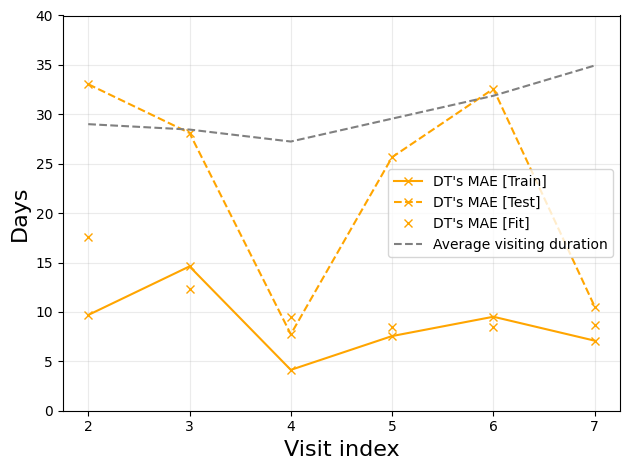

Samples per previous visits count: [381, 325, 278, 243, 212, 188]
Individauls per previous visits count: [56, 47, 35, 31, 24, 20]


In [ ]:
# try to find a connection between staying durations in the individaul level
individuals_df = visits_df.groupby(["p_index"])
stay_per_individaul = [list(list(ind_list)[1]) for ind_list in individuals_df["stay_duration"]]
tail_lens = list(range(2, 8))

tpot_model_preformace_train = []
non_linear_model_preformace_train = []
dt_preformace_train = []
linear_model_preformace_train = []

tpot_model_preformace_test = []
non_linear_model_preformace_test = []
dt_preformace_test = []
linear_model_preformace_test = []

tpot_model_preformace_fit = []
non_linear_model_preformace_fit = []
dt_preformace_fit = []
linear_model_preformace_fit = []

sample_count = []
ind_count = []
avg_visiting_duration = []

for tail_len in tail_lens:
  rows = []
  this_ind_count = 0
  for stay_per_individaul_list in stay_per_individaul:
    if len(stay_per_individaul_list) > tail_len:
      this_ind_count += 1
      for index in range(tail_len, len(stay_per_individaul_list)):
        rows.append([stay_per_individaul_list[index - tail_index] for tail_index in range(tail_len+1)])
  ind_count.append(this_ind_count)
  columns = ["p_visit_{}".format(tail_len - tail_index) for tail_index in range(tail_len)]
  columns.append("this_visit")
  visits_stay_duration_df = pd.DataFrame(rows,
                                        columns=columns) 
  # should not happen but just in case
  visits_stay_duration_df.dropna(inplace=True)
  for col in list(visits_stay_duration_df):
    visits_stay_duration_df[col] = pd.to_numeric(visits_stay_duration_df[col], errors='coerce')
  x = visits_stay_duration_df.drop(["this_visit"], axis=1)
  # edge case for the sklearn library asking X to be 2d
  if x.shape[1] == 1:
    x = pd.DataFrame([[row] for row_index, row in x.iterrows()])
  y = visits_stay_duration_df["this_visit"]
  
  X_train, X_test, y_train, y_test = train_test_split(x,
                                                      y,
                                                      train_size=0.8)

  avg_visiting_duration.append(np.mean(y))

  tpot_model = TPOTRegressor(generations=2,
                             population_size=2,
                             verbosity=2,
                             cv=5)
  tpot_model.fit(X_train, y_train)
  y_pred_train = tpot_model.predict(X_train)
  tpot_model_preformace_train.append(mean_absolute_error(y_train, 
                                                         y_pred_train))
  y_pred_test = tpot_model.predict(X_test)
  tpot_model_preformace_test.append(mean_absolute_error(y_test, 
                                                        y_pred_test))

  tpot_model = TPOTRegressor(generations=2,
                             population_size=2,
                             verbosity=2,
                             cv=5)
  tpot_model.fit(x, y)
  y_pred = tpot_model.predict(x)
  tpot_model_preformace_fit.append(mean_absolute_error(y, 
                                                        y_pred))

  non_linear_model = RandomForestRegressor(max_depth=7)
  non_linear_model.fit(X_train, y_train)
  y_pred_train = non_linear_model.predict(X_train)
  non_linear_model_preformace_train.append(mean_absolute_error(y_train, 
                                                               y_pred_train))
  y_pred_test = non_linear_model.predict(X_test)
  non_linear_model_preformace_test.append(mean_absolute_error(y_test, 
                                                               y_pred_test))
  non_linear_model = RandomForestRegressor(max_depth=7)
  non_linear_model.fit(x, y)
  y_pred = non_linear_model.predict(x)
  non_linear_model_preformace_fit.append(mean_absolute_error(y, 
                                                             y_pred))
  
  
  dt_model = DecisionTreeRegressor(max_depth=7)
  dt_model.fit(X_train, y_train)
  print_df_to_file(dt_model, list(x), "visit_duration_train_test_q2_tail_{}.txt".format(tail_len))
  y_pred_train = dt_model.predict(X_train)
  dt_preformace_train.append(mean_absolute_error(y_train, 
                                                               y_pred_train))
  y_pred_test = dt_model.predict(X_test)
  dt_preformace_test.append(mean_absolute_error(y_test, 
                                                               y_pred_test))
  dt_model = DecisionTreeRegressor(max_depth=7)
  dt_model.fit(x, y)
  print_df_to_file(dt_model, list(x), "visit_duration_fit_q2_tail_{}.txt".format(tail_len))
  y_pred = dt_model.predict(x)
  dt_preformace_fit.append(mean_absolute_error(y, 
                                                             y_pred))

  linear_model = LinearRegression()
  linear_model.fit(X_train, y_train)
  y_pred_train = linear_model.predict(X_train)
  linear_model_preformace_train.append(mean_absolute_error(y_train, 
                                                           y_pred_train))
  y_pred_test = linear_model.predict(X_test)
  linear_model_preformace_test.append(mean_absolute_error(y_test, 
                                                           y_pred_test))
  
  linear_model = LinearRegression()
  linear_model.fit(x, y)
  y_pred = linear_model.predict(x)
  linear_model_preformace_fit.append(mean_absolute_error(y, 
                                                         y_pred))
  
  sample_count.append(x.shape[0])
# print results 
"""
plt.plot(tail_lens,
         tpot_model_preformace_train,
         "-o",
         color="green",
         label="TPOT's MAE [Train]")
plt.plot(tail_lens,
         tpot_model_preformace_test,
         "--o",
         color="green",
         label="TPOT's MAE [Test]")
plt.plot(tail_lens,
         tpot_model_preformace_fit,
         "o",
         color="green",
         label="TPOT's MAE [Fit]")

plt.plot(tail_lens,
         non_linear_model_preformace_train,
         "-^",
         color="blue",
         label="RF's MAE [Train]")
plt.plot(tail_lens,
         non_linear_model_preformace_test,
         "--^",
         color="blue",
         label="RF's MAE [Test]")
plt.plot(tail_lens,
         non_linear_model_preformace_fit,
         "^",
         color="blue",
         label="RF's MAE [Fit]")

plt.plot(tail_lens,
         linear_model_preformace_train,
         "-x",
         color="red",
         label="LR's MAE [Train]")
plt.plot(tail_lens,
         linear_model_preformace_test,
         "--x",
         color="red",
         label="LR's MAE [Test]")
plt.plot(tail_lens,
         linear_model_preformace_fit,
         "x",
         color="red",
         label="LR's MAE [Fit]")
"""

plt.plot(tail_lens,
         dt_preformace_train,
         "-x",
         color="orange",
         label="DT's MAE [Train]")
plt.plot(tail_lens,
         dt_preformace_test,
         "--x",
         color="orange",
         label="DT's MAE [Test]")
plt.plot(tail_lens,
         dt_preformace_fit,
         "x",
         color="orange",
         label="DT's MAE [Fit]")

plt.plot(tail_lens,
         avg_visiting_duration,
         "--",
         color="gray",
         label="Average visiting duration")
plt.xlabel("Visit index", fontsize=16)
plt.ylabel("Days", fontsize=16)
plt.ylim((0, 40))
plt.xticks(tail_lens)
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig("previous_visits_rf_mae_connection.png", dpi=300)
plt.show()
plt.close()
print("Samples per previous visits count: {}".format(sample_count))
print("Individauls per previous visits count: {}".format(ind_count))

### Third question:
Extend the model in question #2 to also have the pearson level data at each sample for the models 

Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -3318.433339497041

Generation 2 - Current best internal CV score: -3318.433339497041

Best pipeline: ElasticNetCV(input_matrix, l1_ratio=0.7000000000000001, tol=0.1)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -1779.600198705007

Generation 2 - Current best internal CV score: -1779.600198705007

Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=80, p=2, weights=distance)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -1498.1366179582806

Generation 2 - Current best internal CV score: -1498.1366179582806

Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=37, p=1, weights=distance)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2579.351675628916

Generation 2 - Current best internal CV score: -2579.351675628916

Best pipeline: AdaBoostRegressor(ZeroCount(input_matrix), learning_rate=0.001, loss=square, n_estimators=100)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -1993.0839651054187

Generation 2 - Current best internal CV score: -1993.0839651054187

Best pipeline: AdaBoostRegressor(XGBRegressor(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=13, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.3, verbosity=0), learning_rate=0.5, loss=exponential, n_estimators=100)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -948.1200260483641

Generation 2 - Current best internal CV score: -948.1200260483641

Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=0.1, loss=linear, n_estimators=100)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -4146.652552599935

Generation 2 - Current best internal CV score: -4146.652552599935

Best pipeline: LassoLarsCV(RobustScaler(input_matrix), normalize=False)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -986.6966611870387

Generation 2 - Current best internal CV score: -986.6966611870387

Best pipeline: AdaBoostRegressor(VarianceThreshold(input_matrix, threshold=0.001), learning_rate=0.1, loss=square, n_estimators=100)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -1892.2623717232266

Generation 2 - Current best internal CV score: -1892.2623717232266

Best pipeline: AdaBoostRegressor(CombineDFs(input_matrix, input_matrix), learning_rate=0.5, loss=square, n_estimators=100)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -4111.051184583352

Generation 2 - Current best internal CV score: -4111.051184583352

Best pipeline: LinearSVR(Nystroem(input_matrix, gamma=0.30000000000000004, kernel=sigmoid, n_components=4), C=25.0, dual=True, epsilon=0.001, loss=squared_epsilon_insensitive, tol=0.01)


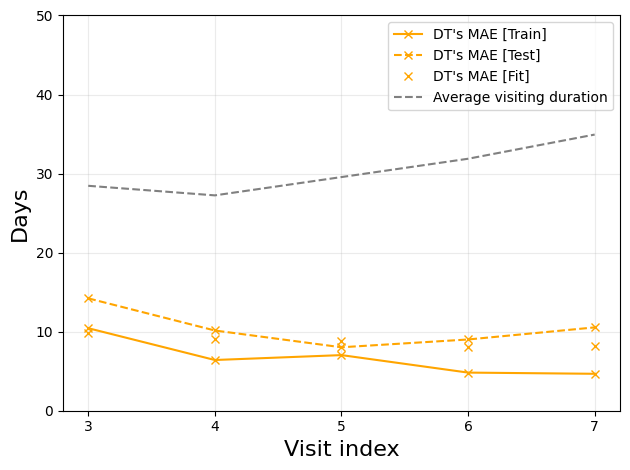

Samples per previous visits count: [325, 278, 243, 212, 188]
Individauls per previous visits count: [47, 35, 31, 24, 20]


In [ ]:
# try to find a connection between staying durations in the individaul level
stay_per_individaul = [list(list(ind_list)[1]) for ind_list in individuals_df["stay_duration"]]
tail_lens = list(range(3, 8))

tpot_model_preformace_train = []
non_linear_model_preformace_train = []
dt_preformace_train = []
linear_model_preformace_train = []

tpot_model_preformace_test = []
non_linear_model_preformace_test = []
dt_preformace_test = []
linear_model_preformace_test = []

tpot_model_preformace_fit = []
non_linear_model_preformace_fit = []
dt_preformace_fit = []
linear_model_preformace_fit = []

sample_count = []
ind_count = []
avg_visiting_duration = []

for tail_len in tail_lens:
  rows = []
  this_ind_count = 0
  for p_index, stay_per_individaul_list in enumerate(stay_per_individaul):
    if len(stay_per_individaul_list) > tail_len:
      this_ind_count += 1
      for index in range(tail_len, len(stay_per_individaul_list)):
        rows.append([stay_per_individaul_list[index - tail_index] for tail_index in range(tail_len+1)])
        # This part is basically the improvment over question #2
        extra_data = individuals_df.nth(0).iloc[p_index, :]
        extra_data.drop(["stay_duration", "issue_date", "treatment", "education"], inplace=True)
        rows[-1].extend(extra_data)
  ind_count.append(this_ind_count)
  visits_stay_duration_df = pd.DataFrame(rows) 
  # should not happen but just in case
  visits_stay_duration_df.dropna(inplace=True)
  for col in list(visits_stay_duration_df):
    visits_stay_duration_df[col] = pd.to_numeric(visits_stay_duration_df[col], errors='coerce')
  x = visits_stay_duration_df.drop([list(visits_stay_duration_df)[tail_len]], axis=1)
  # edge case for the sklearn library asking X to be 2d
  if x.shape[1] == 1:
    x = pd.DataFrame([[row] for row_index, row in x.iterrows()])
  y = visits_stay_duration_df[list(visits_stay_duration_df)[tail_len]]
  
  
  X_train, X_test, y_train, y_test = train_test_split(x,
                                                      y,
                                                      train_size=0.8)

  avg_visiting_duration.append(np.mean(y))

  tpot_model = TPOTRegressor(generations=2,
                             population_size=2,
                             verbosity=2,
                             cv=5)
  tpot_model.fit(X_train, y_train)
  y_pred_train = tpot_model.predict(X_train)
  tpot_model_preformace_train.append(mean_absolute_error(y_train, 
                                                         y_pred_train))
  y_pred_test = tpot_model.predict(X_test)
  tpot_model_preformace_test.append(mean_absolute_error(y_test, 
                                                        y_pred_test))

  tpot_model = TPOTRegressor(generations=2,
                             population_size=2,
                             verbosity=2,
                             cv=5)
  tpot_model.fit(x, y)
  y_pred = tpot_model.predict(x)
  tpot_model_preformace_fit.append(mean_absolute_error(y, 
                                                        y_pred))

  non_linear_model = RandomForestRegressor(max_depth=7)
  non_linear_model.fit(X_train, y_train)
  y_pred_train = non_linear_model.predict(X_train)
  non_linear_model_preformace_train.append(mean_absolute_error(y_train, 
                                                               y_pred_train))
  y_pred_test = non_linear_model.predict(X_test)
  non_linear_model_preformace_test.append(mean_absolute_error(y_test, 
                                                               y_pred_test))
  non_linear_model = RandomForestRegressor(max_depth=7)
  non_linear_model.fit(x, y)
  y_pred = non_linear_model.predict(x)
  non_linear_model_preformace_fit.append(mean_absolute_error(y, 
                                                             y_pred))
  
  dt_model = DecisionTreeRegressor(max_depth=7)
  dt_model.fit(X_train, y_train)
  print_df_to_file(dt_model, list(x),"visit_duration_train_test_q3_tail_{}.txt".format(tail_len))
  y_pred_train = dt_model.predict(X_train)
  dt_preformace_train.append(mean_absolute_error(y_train, 
                                                               y_pred_train))
  y_pred_test = dt_model.predict(X_test)
  dt_preformace_test.append(mean_absolute_error(y_test, 
                                                               y_pred_test))
  dt_model = DecisionTreeRegressor(max_depth=7)
  dt_model.fit(x, y)
  print_df_to_file(dt_model, list(x),"visit_duration_fit_q3_tail_{}.txt".format(tail_len))
  y_pred = dt_model.predict(x)
  dt_preformace_fit.append(mean_absolute_error(y, 
                                                             y_pred))

  linear_model = LinearRegression()
  linear_model.fit(X_train, y_train)
  y_pred_train = linear_model.predict(X_train)
  linear_model_preformace_train.append(mean_absolute_error(y_train, 
                                                           y_pred_train))
  y_pred_test = linear_model.predict(X_test)
  linear_model_preformace_test.append(mean_absolute_error(y_test, 
                                                           y_pred_test))
  
  linear_model = LinearRegression()
  linear_model.fit(x, y)
  y_pred = linear_model.predict(x)
  linear_model_preformace_fit.append(mean_absolute_error(y, 
                                                         y_pred))
  
  sample_count.append(x.shape[0])
# print results 
"""
plt.plot(tail_lens,
         tpot_model_preformace_train,
         "-o",
         color="green",
         label="TPOT's MAE [Train]")
plt.plot(tail_lens,
         tpot_model_preformace_test,
         "--o",
         color="green",
         label="TPOT's MAE [Test]")
plt.plot(tail_lens,
         tpot_model_preformace_fit,
         "o",
         color="green",
         label="TPOT's MAE [Fit]")

plt.plot(tail_lens,
         non_linear_model_preformace_train,
         "-^",
         color="blue",
         label="RF's MAE [Train]")
plt.plot(tail_lens,
         non_linear_model_preformace_test,
         "--^",
         color="blue",
         label="RF's MAE [Test]")
plt.plot(tail_lens,
         non_linear_model_preformace_fit,
         "^",
         color="blue",
         label="RF's MAE [Fit]")

plt.plot(tail_lens,
         linear_model_preformace_train,
         "-x",
         color="red",
         label="LR's MAE [Train]")
plt.plot(tail_lens,
         linear_model_preformace_test,
         "--x",
         color="red",
         label="LR's MAE [Test]")
plt.plot(tail_lens,
         linear_model_preformace_fit,
         "x",
         color="red",
         label="LR's MAE [Fit]")
"""

plt.plot(tail_lens,
         dt_preformace_train,
         "-x",
         color="orange",
         label="DT's MAE [Train]")
plt.plot(tail_lens,
         dt_preformace_test,
         "--x",
         color="orange",
         label="DT's MAE [Test]")
plt.plot(tail_lens,
         dt_preformace_fit,
         "x",
         color="orange",
         label="DT's MAE [Fit]")

plt.plot(tail_lens,
         avg_visiting_duration,
         "--",
         color="gray",
         label="Average visiting duration")
plt.xlabel("Visit index", fontsize=16)
plt.ylabel("Days", fontsize=16)
plt.ylim((0, 50))
plt.xticks(tail_lens)
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig("previous_visits_rf_mae_connection.png", dpi=300)
plt.show()
plt.close()

print("Samples per previous visits count: {}".format(sample_count))
print("Individauls per previous visits count: {}".format(ind_count))

### Forth question:
Basically, we wish to repeat the previous three calculations but with time_to_stay

In [ ]:
# We need to understand how we calcuate the time to next 
visits_df = pd.read_csv("data2.csv")
visits_df = visits_df[~np.isnan(visits_df["p_index"])]
visits_df = visits_df.drop_duplicates(subset=['issue_date','p_index'], keep="first")
visits_df['issue_date'] = pd.to_datetime(visits_df['issue_date'])
visits_df.reset_index(inplace=True, drop=True)
for col in ["current_age", "gender", "is_new", "stay_duration", "age", "education", "family_status"]:
  visits_df[col] = pd.to_numeric(visits_df[col], errors='coerce')

individuals_df = visits_df.groupby(["p_index"])
for name, group in individuals_df:
  group.sort_values(by=["issue_date"], inplace=True)

print("individuals_df size is {}".format(len(individuals_df)))
individuals_df = [group for name, group in individuals_df if group.shape[0] > 1]
print("individuals_df size is {} after removing one-visiters".format(len(individuals_df)))

issue_date_col_index = 3

for group in individuals_df:
  new_col = [None]
  for row_index in range(1, len(group)):
    new_col.append((group.iloc[row_index, issue_date_col_index] - group.iloc[row_index-1, issue_date_col_index]).days)
  group["next_time_visit"] = new_col
  group.dropna(inplace=True)

print("individuals_df size after removing nans and preparing data - {}".format(len(individuals_df)))
individuals_df = [group for group in individuals_df if group.shape[0] > 0]
print("individuals_df size after removing empty individual sets - {}".format(len(individuals_df)))

<ipython-input-35-87ca6196aade>:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  visits_df['issue_date'] = pd.to_datetime(visits_df['issue_date'])
<ipython-input-35-87ca6196aade>:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in individuals_df:
<ipython-input-35-87ca6196aade>:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  individuals_df = [group for name, group in individuals_df if group.shape[0] > 1]


individuals_df size is 200
individuals_df size is 129 after removing one-visiters
individuals_df size after removing nans and preparing data - 129
individuals_df size after removing empty individual sets - 75


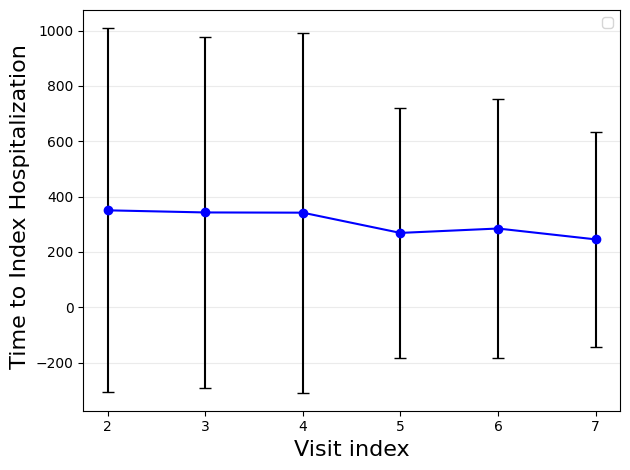

Samples per previous visits count: [338, 289, 252, 219, 195, 175]
Individauls per previous visits count: [49, 37, 33, 24, 20, 19]
means: [350.59, 342.92, 342.13, 268.97, 284.84, 245.61]
stds: [658.2, 634.33, 649.99, 450.38, 469.32, 389.69]


In [ ]:
# try to find a connection between staying durations in the individaul level
stay_per_individaul = [group["next_time_visit"] for group in individuals_df]
tail_lens = list(range(2, 8))

sample_count = []
ind_count = []
means = []
stds = []

for tail_len in tail_lens:
  rows = []
  this_ind_count = 0
  for stay_per_individaul_list in stay_per_individaul:
    if len(stay_per_individaul_list) > tail_len:
      this_ind_count += 1
      for index in range(tail_len, len(stay_per_individaul_list)):
        rows.append([stay_per_individaul_list.iloc[index - tail_index] for tail_index in range(tail_len+1)])
  ind_count.append(this_ind_count)
  columns = ["p_visit_{}".format(tail_len - tail_index) for tail_index in range(tail_len)]
  columns.append("this_visit")
  visits_stay_duration_df = pd.DataFrame(rows,
                                        columns=columns) 
  # should not happen but just in case
  visits_stay_duration_df.dropna(inplace=True)
  means.append(np.mean(visits_stay_duration_df["this_visit"]))
  stds.append(np.std(visits_stay_duration_df["this_visit"])) 
  sample_count.append(visits_stay_duration_df.shape[0])

# print results 
plt.errorbar(x=tail_lens,
             y=means,
             yerr=stds,
             marker="o",
             capsize=4,
             ecolor="black",
             color="blue")
plt.xlabel("Visit index", fontsize=16)
plt.ylabel(" Time to Index Hospitalization", fontsize=16)
#plt.ylim((-50, 100))
plt.xticks(tail_lens)
plt.grid(alpha=0.25,
         axis="y")
plt.legend()
plt.tight_layout()
plt.savefig("time_series_next_visit.png", dpi=300)
plt.show()
plt.close()
print("Samples per previous visits count: {}".format(sample_count))
print("Individauls per previous visits count: {}".format(ind_count))
print("means: {}\nstds: {}".format([round(val, 2) for val in means], [round(val, 2) for val in stds]))

cross-individuals = 85.714%
Person: PearsonRResult(statistic=-0.24421261239950057, pvalue=1.5564144400704616e-07)
Spearman: SignificanceResult(statistic=-0.2703659868799234, pvalue=5.600505130790219e-09)


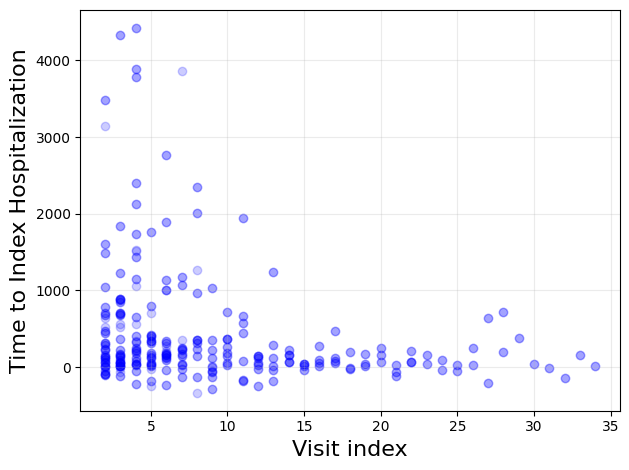

'\nfor visit_index in range(11):\n  this_df = df[df["index"] == visit_index]\n  this_df["stay"].hist(bins=20)\n  plt.xlabel("Stay duration")\n  plt.ylabel("Count")\n  plt.title("Visit index = {}".format(visit_index+1))\n  plt.show()\n  plt.close()\n'

In [ ]:

# try to find a connection between staying durations in the individaul level
stay_per_individaul = [group["next_time_visit"] for group in individuals_df]
tail_lens = list(range(2, 8))

index = []
stay_duration = []
tested_crosser = 0
problematic_crosser = 0

for stay_per_individaul_list in stay_per_individaul:
  if len(stay_per_individaul_list) > 1:
    for i in range(len(stay_per_individaul_list)):
      index.append(i)
      stay_duration.append(stay_per_individaul_list.iloc[i])
    
  if len(stay_per_individaul_list) > 2:
    if any([val > 365 for val in stay_per_individaul_list[1:]]) and any([val < 365 for val in stay_per_individaul_list[1:]]):
      problematic_crosser += 1
    tested_crosser += 1
print("cross-individuals = {:.3f}%".format(100*problematic_crosser/tested_crosser))

df = pd.DataFrame(np.array([index, stay_duration]).transpose(),
                  columns=["index", "stay"])
#df = df[df["index"] < 9]
df.dropna(inplace=True)

print("Person: {}".format(pearsonr(df.iloc[:, 0], df.iloc[:, 1])))
print("Spearman: {}".format(spearmanr(df.iloc[:, 0], df.iloc[:, 1])))

# print results 
plt.scatter(df["index"]+2,
            df["stay"],
             marker="o",
             color="blue",
            alpha=0.2)
plt.xlabel("Visit index", fontsize=16)
plt.ylabel("Time to Index Hospitalization", fontsize=16)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("index_vs_visit_duration.png", dpi=300)
plt.show()
plt.close()

# ----------------------------------- # 

"""
for visit_index in range(11):
  this_df = df[df["index"] == visit_index]
  this_df["stay"].hist(bins=20)
  plt.xlabel("Stay duration")
  plt.ylabel("Count")
  plt.title("Visit index = {}".format(visit_index+1))
  plt.show()
  plt.close()
"""




In [ ]:
# should not happen but just in case
visits_reconstracted = pd.concat(individuals_df)
x = visits_reconstracted.drop(["next_time_visit", "issue_date", "treatment"], axis=1)
y = visits_reconstracted["next_time_visit"]
print("Working with {} samples and {} features".format(x.shape[0], x.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    train_size=0.8)

print("Baseline: train = {:.3f}, test = {:.3f}, fit = {:.3f}".format(np.mean(y_train),
                                                                     np.mean(y_test),
                                                                     np.mean(y)))

tpot = TPOTRegressor(generations=2,
                     population_size=2,
                     cv=5)
tpot.fit(x, y)
y_pred = tpot.predict(x)

tpot = TPOTRegressor(generations=2,
                     population_size=2,
                     cv=5)
tpot.fit(X_train, y_train)
tpot.export('just_visit_df_stay_duration.py')
y_pred_train = tpot.predict(X_train)
y_pred_test  = tpot.predict(X_test)
print("TPOT")
print("Model's MAE (train) = {:.3f}\nModel's MAE (test) = {:.3f}\nModel's MAE (fit) = {:.3f}".format(mean_absolute_error(y_train,
                                                                                             y_pred_train),
                                                                         mean_absolute_error(y_test,
                                                                                             y_pred_test),
                                                                         mean_absolute_error(y,
                                                                                             y_pred)))

rf_model = RandomForestRegressor(max_depth=7)
rf_model.fit(x, y)
y_pred = rf_model.predict(x)

rf_model = RandomForestRegressor(max_depth=7)
rf_model.fit(X_train, y_train)
y_pred_train = rf_model.predict(X_train)
y_pred_test  = rf_model.predict(X_test)
print("Random Forest")
print("Model's MAE (train) = {:.3f}\nModel's MAE (test) = {:.3f}\nModel's MAE (fit) = {:.3f}".format(mean_absolute_error(y_train,
                                                                                             y_pred_train),
                                                                         mean_absolute_error(y_test,
                                                                                             y_pred_test),
                                                                         mean_absolute_error(y,
                                                                                             y_pred)))

dt_model = DecisionTreeRegressor(max_depth=7)
dt_model.fit(x, y)
y_pred = dt_model.predict(x)
print_df_to_file(dt_model, list(x),"next_visit_fit.txt")

dt_model = DecisionTreeRegressor(max_depth=7)
dt_model.fit(X_train, y_train)
print_df_to_file(dt_model, list(x),"next_visit_train_test.txt")
y_pred_train = dt_model.predict(X_train)
y_pred_test  = dt_model.predict(X_test)
print("Decision Tree")
print("Model's MAE (train) = {:.3f}\nModel's MAE (test) = {:.3f}\nModel's MAE (fit) = {:.3f}".format(mean_absolute_error(y_train,
                                                                                             y_pred_train),
                                                                         mean_absolute_error(y_test,
                                                                                             y_pred_test),
                                                                         mean_absolute_error(y,
                                                                                             y_pred)))

lr_model = LinearRegression()
lr_model.fit(x, y)
y_pred = lr_model.predict(x)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_train = lr_model.predict(X_train)
y_pred_test  = lr_model.predict(X_test)
print("Linear Regression")
print("Model's MAE (train) = {:.3f}\nModel's MAE (test) = {:.3f}\nModel's MAE (fit) = {:.3f}".format(mean_absolute_error(y_train,
                                                                                             y_pred_train),
                                                                         mean_absolute_error(y_test,
                                                                                             y_pred_test),
                                                                         mean_absolute_error(y,
                                                                                             y_pred)))

Working with 469 samples and 21 features
Baseline: train = 459.685, test = 303.606, fit = 428.403
TPOT
Model's MAE (train) = 512.617
Model's MAE (test) = 423.266
Model's MAE (fit) = 251.165
Random Forest
Model's MAE (train) = 227.887
Model's MAE (test) = 393.651
Model's MAE (fit) = 233.032
Decision Tree
Model's MAE (train) = 175.742
Model's MAE (test) = 323.845
Model's MAE (fit) = 191.460
Linear Regression
Model's MAE (train) = 505.094
Model's MAE (test) = 447.940
Model's MAE (fit) = 479.466


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -508005.72091049387

Generation 2 - Current best internal CV score: -476385.8195358658

Best pipeline: ElasticNetCV(RBFSampler(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), gamma=0.30000000000000004), l1_ratio=0.15000000000000002, tol=0.1)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -222713.04560076297

Generation 2 - Current best internal CV score: -222713.04560076297

Best pipeline: XGBRegressor(input_matrix, learning_rate=0.5, max_depth=5, min_child_weight=6, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.25, verbosity=0)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -346776.88747280196

Generation 2 - Current best internal CV score: -346776.88747280196

Best pipeline: AdaBoostRegressor(FastICA(input_matrix, tol=0.5), learning_rate=0.001, loss=exponential, n_estimators=100)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -369922.8201468213

Generation 2 - Current best internal CV score: -259657.00211585598

Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=0.01, loss=square, n_estimators=100)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -392112.6379895904

Generation 2 - Current best internal CV score: -392112.6379895904

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.9000000000000001, min_samples_leaf=9, min_samples_split=3, n_estimators=100)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -311954.2684260508

Generation 2 - Current best internal CV score: -311954.2684260508

Best pipeline: RidgeCV(XGBRegressor(input_matrix, learning_rate=0.5, max_depth=9, min_child_weight=11, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.2, verbosity=0))


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -183017.17905269022

Generation 2 - Current best internal CV score: -183017.07090038844

Best pipeline: ElasticNetCV(input_matrix, l1_ratio=0.8, tol=1e-05)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -140065.51570491967

Generation 2 - Current best internal CV score: -140065.51570491967

Best pipeline: RandomForestRegressor(LinearSVR(input_matrix, C=15.0, dual=False, epsilon=0.001, loss=squared_epsilon_insensitive, tol=0.0001), bootstrap=False, max_features=0.2, min_samples_leaf=10, min_samples_split=19, n_estimators=100)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -149428.73631189734

Generation 2 - Current best internal CV score: -139766.78418497148

Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=0.5, loss=exponential, n_estimators=100)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -107291.67866963202

Generation 2 - Current best internal CV score: -92375.94054429067

Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=1.0, loss=exponential, n_estimators=100)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -145084.61514357998

Generation 2 - Current best internal CV score: -145084.61514357998

Best pipeline: XGBRegressor(input_matrix, learning_rate=0.5, max_depth=3, min_child_weight=9, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.1, verbosity=0)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -87743.38589388323

Generation 2 - Current best internal CV score: -87743.38589388323

Best pipeline: RandomForestRegressor(RBFSampler(input_matrix, gamma=0.1), bootstrap=False, max_features=0.3, min_samples_leaf=14, min_samples_split=11, n_estimators=100)


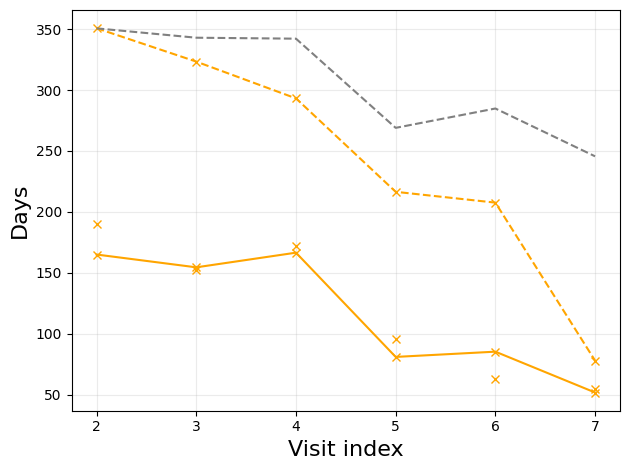

Samples per previous visits count: [338, 289, 252, 219, 195, 175]
Individauls per previous visits count: [49, 37, 33, 24, 20, 19]


In [ ]:
stay_per_individaul = [group["next_time_visit"] for group in individuals_df]
tail_lens = list(range(2, 8))

tpot_model_preformace_train = []
non_linear_model_preformace_train = []
dt_preformace_train = []
linear_model_preformace_train = []

tpot_model_preformace_test = []
non_linear_model_preformace_test = []
dt_preformace_test = []
linear_model_preformace_test = []

tpot_model_preformace_fit = []
non_linear_model_preformace_fit = []
dt_preformace_fit = []
linear_model_preformace_fit = []


sample_count = []
ind_count = []
avg_visiting_duration = []

for tail_len in tail_lens:
  rows = []
  this_ind_count = 0
  for stay_per_individaul_list in stay_per_individaul:
    if len(stay_per_individaul_list) > tail_len:
      this_ind_count += 1
      for index in range(tail_len, len(stay_per_individaul_list)):
        rows.append([stay_per_individaul_list.iloc[index - tail_index] for tail_index in range(tail_len+1)])
  ind_count.append(this_ind_count)
  columns = ["p_visit_{}".format(tail_len - tail_index) for tail_index in range(tail_len)]
  columns.append("this_visit")
  visits_stay_duration_df = pd.DataFrame(rows,
                                        columns=columns) 
  # should not happen but just in case
  visits_stay_duration_df.dropna(inplace=True)
  for col in list(visits_stay_duration_df):
    visits_stay_duration_df[col] = pd.to_numeric(visits_stay_duration_df[col], errors='coerce')
  x = visits_stay_duration_df.drop(["this_visit"], axis=1)
  # edge case for the sklearn library asking X to be 2d
  if x.shape[1] == 1:
    x = pd.DataFrame([[row] for row_index, row in x.iterrows()])
  y = visits_stay_duration_df["this_visit"]
  
  X_train, X_test, y_train, y_test = train_test_split(x,
                                                      y,
                                                      train_size=0.8)

  avg_visiting_duration.append(np.mean(y))

  tpot_model = TPOTRegressor(generations=2,
                             population_size=2,
                             verbosity=2,
                             cv=5)
  tpot_model.fit(X_train, y_train)
  y_pred_train = tpot_model.predict(X_train)
  tpot_model_preformace_train.append(mean_absolute_error(y_train, 
                                                         y_pred_train))
  y_pred_test = tpot_model.predict(X_test)
  tpot_model_preformace_test.append(mean_absolute_error(y_test, 
                                                        y_pred_test))

  tpot_model = TPOTRegressor(generations=2,
                             population_size=2,
                             verbosity=2,
                             cv=5)
  tpot_model.fit(x, y)
  y_pred = tpot_model.predict(x)
  tpot_model_preformace_fit.append(mean_absolute_error(y, 
                                                        y_pred))

  non_linear_model = RandomForestRegressor(max_depth=7)
  non_linear_model.fit(X_train, y_train)
  y_pred_train = non_linear_model.predict(X_train)
  non_linear_model_preformace_train.append(mean_absolute_error(y_train, 
                                                               y_pred_train))
  y_pred_test = non_linear_model.predict(X_test)
  non_linear_model_preformace_test.append(mean_absolute_error(y_test, 
                                                               y_pred_test))
  non_linear_model = RandomForestRegressor(max_depth=7)
  non_linear_model.fit(x, y)
  y_pred = non_linear_model.predict(x)
  non_linear_model_preformace_fit.append(mean_absolute_error(y, 
                                                             y_pred))
  
  dt_model = DecisionTreeRegressor(max_depth=7)
  dt_model.fit(X_train, y_train)
  print_df_to_file(dt_model,list(x), "next_visit_train_test_q2_tail_{}.txt".format(tail_len))
  y_pred_train = dt_model.predict(X_train)
  dt_preformace_train.append(mean_absolute_error(y_train, 
                                                               y_pred_train))
  y_pred_test = dt_model.predict(X_test)
  dt_preformace_test.append(mean_absolute_error(y_test, 
                                                               y_pred_test))
  dt_model = DecisionTreeRegressor(max_depth=7)
  dt_model.fit(x, y)
  print_df_to_file(dt_model,list(x), "next_visit_fit_q2_tail_{}.txt".format(tail_len))
  y_pred = dt_model.predict(x)
  dt_preformace_fit.append(mean_absolute_error(y, 
                                                             y_pred))

  linear_model = LinearRegression()
  linear_model.fit(X_train, y_train)
  y_pred_train = linear_model.predict(X_train)
  linear_model_preformace_train.append(mean_absolute_error(y_train, 
                                                           y_pred_train))
  y_pred_test = linear_model.predict(X_test)
  linear_model_preformace_test.append(mean_absolute_error(y_test, 
                                                           y_pred_test))
  
  linear_model = LinearRegression()
  linear_model.fit(x, y)
  y_pred = linear_model.predict(x)
  linear_model_preformace_fit.append(mean_absolute_error(y, 
                                                         y_pred))
  
  sample_count.append(x.shape[0])
# print results 
"""
plt.plot(tail_lens,
         tpot_model_preformace_train,
         "-o",
         color="green",
         label="TPOT's MAE [Train]")
plt.plot(tail_lens,
         tpot_model_preformace_test,
         "--o",
         color="green",
         label="TPOT's MAE [Test]")
plt.plot(tail_lens,
         tpot_model_preformace_fit,
         "o",
         color="green",
         label="TPOT's MAE [Fit]")

plt.plot(tail_lens,
         non_linear_model_preformace_train,
         "-^",
         color="blue",
         label="RF's MAE [Train]")
plt.plot(tail_lens,
         non_linear_model_preformace_test,
         "--^",
         color="blue",
         label="RF's MAE [Test]")
plt.plot(tail_lens,
         non_linear_model_preformace_fit,
         "^",
         color="blue",
         label="RF's MAE [Fit]")

plt.plot(tail_lens,
         linear_model_preformace_train,
         "-x",
         color="red",
         label="LR's MAE [Train]")
plt.plot(tail_lens,
         linear_model_preformace_test,
         "--x",
         color="red",
         label="LR's MAE [Test]")
plt.plot(tail_lens,
         linear_model_preformace_fit,
         "x",
         color="red",
         label="LR's MAE [Fit]")
"""


plt.plot(tail_lens,
         dt_preformace_train,
         "-x",
         color="orange",
         label="DT's MAE [Train]")
plt.plot(tail_lens,
         dt_preformace_test,
         "--x",
         color="orange",
         label="DT's MAE [Test]")
plt.plot(tail_lens,
         dt_preformace_fit,
         "x",
         color="orange",
         label="DT's MAE [Fit]")

plt.plot(tail_lens,
         avg_visiting_duration,
         "--",
         color="gray",
         label="Average visiting duration")
plt.xlabel("Visit index", fontsize=16)
plt.ylabel("Days", fontsize=16)
plt.xticks(tail_lens)
plt.grid(alpha=0.25)
#plt.legend()
plt.tight_layout()
plt.savefig("previous_to_next_visit_mae_connection.png", dpi=300)
plt.show()
plt.close()
print("Samples per previous visits count: {}".format(sample_count))
print("Individauls per previous visits count: {}".format(ind_count))

<ipython-input-40-c7afc5c33825>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_data.drop(["next_time_visit", "issue_date", "treatment", "education"], inplace=True)
<ipython-input-40-c7afc5c33825>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_data.drop(["next_time_visit", "issue_date", "treatment", "education"], inplace=True)
<ipython-input-40-c7afc5c33825>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_data.

Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -350197.56353360985

Generation 2 - Current best internal CV score: -301118.8772137459

Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=1.0, loss=square, n_estimators=100)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -398251.56994462275

Generation 2 - Current best internal CV score: -263438.9347747648

Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=13, p=1, weights=distance)


<ipython-input-40-c7afc5c33825>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_data.drop(["next_time_visit", "issue_date", "treatment", "education"], inplace=True)
<ipython-input-40-c7afc5c33825>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_data.drop(["next_time_visit", "issue_date", "treatment", "education"], inplace=True)
<ipython-input-40-c7afc5c33825>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_data.

Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -290867.4832393568

Generation 2 - Current best internal CV score: -286794.7708009572

Best pipeline: RandomForestRegressor(AdaBoostRegressor(input_matrix, learning_rate=0.5, loss=exponential, n_estimators=100), bootstrap=True, max_features=0.7500000000000001, min_samples_leaf=8, min_samples_split=9, n_estimators=100)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -203984.60445068352

Generation 2 - Current best internal CV score: -165225.4294344863

Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=1.0, loss=exponential, n_estimators=100)


<ipython-input-40-c7afc5c33825>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_data.drop(["next_time_visit", "issue_date", "treatment", "education"], inplace=True)
<ipython-input-40-c7afc5c33825>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_data.drop(["next_time_visit", "issue_date", "treatment", "education"], inplace=True)
<ipython-input-40-c7afc5c33825>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_data.

Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -179739.95642854835

Generation 2 - Current best internal CV score: -173839.36889578003

Best pipeline: KNeighborsRegressor(RandomForestRegressor(AdaBoostRegressor(input_matrix, learning_rate=0.001, loss=exponential, n_estimators=100), bootstrap=True, max_features=0.3, min_samples_leaf=19, min_samples_split=2, n_estimators=100), n_neighbors=57, p=1, weights=distance)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -162709.22360950982

Generation 2 - Current best internal CV score: -162709.22360950982

Best pipeline: KNeighborsRegressor(RandomForestRegressor(RidgeCV(input_matrix), bootstrap=False, max_features=0.55, min_samples_leaf=4, min_samples_split=12, n_estimators=100), n_neighbors=71, p=1, weights=uniform)


<ipython-input-40-c7afc5c33825>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_data.drop(["next_time_visit", "issue_date", "treatment", "education"], inplace=True)
<ipython-input-40-c7afc5c33825>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_data.drop(["next_time_visit", "issue_date", "treatment", "education"], inplace=True)
<ipython-input-40-c7afc5c33825>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_data.

Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -165344.25944915204

Generation 2 - Current best internal CV score: -165344.25944915204

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=18, min_samples_split=15, n_estimators=100)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -81077.62580340111

Generation 2 - Current best internal CV score: -81077.62580340111

Best pipeline: XGBRegressor(input_matrix, learning_rate=1.0, max_depth=10, min_child_weight=17, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6500000000000001, verbosity=0)


<ipython-input-40-c7afc5c33825>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_data.drop(["next_time_visit", "issue_date", "treatment", "education"], inplace=True)
<ipython-input-40-c7afc5c33825>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_data.drop(["next_time_visit", "issue_date", "treatment", "education"], inplace=True)
<ipython-input-40-c7afc5c33825>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_data.

Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -167711.44004816335

Generation 2 - Current best internal CV score: -145989.90476628675

Best pipeline: ExtraTreesRegressor(RidgeCV(input_matrix), bootstrap=False, max_features=0.6500000000000001, min_samples_leaf=14, min_samples_split=11, n_estimators=100)


Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -144570.67934810964

Generation 2 - Current best internal CV score: -144358.42672431102

Best pipeline: ElasticNetCV(input_matrix, l1_ratio=0.9, tol=0.0001)


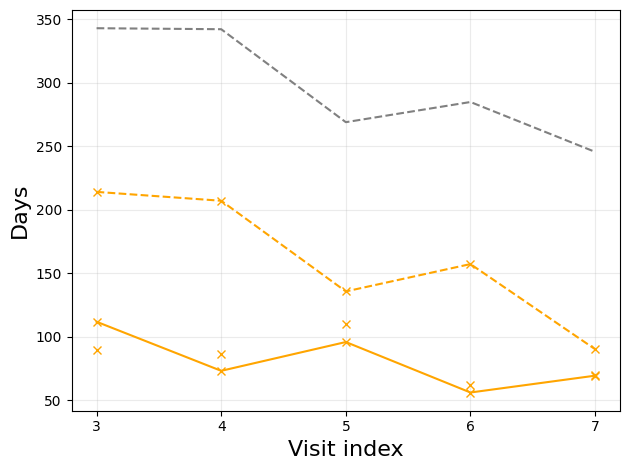

Samples per previous visits count: [289, 252, 219, 195, 175]
Individauls per previous visits count: [37, 33, 24, 20, 19]


In [ ]:
stay_per_individaul = [group["next_time_visit"] for group in individuals_df]
tail_lens = list(range(3, 8))

tpot_model_preformace_train = []
non_linear_model_preformace_train = []
dt_preformace_train = []
linear_model_preformace_train = []

tpot_model_preformace_test = []
non_linear_model_preformace_test = []
dt_preformace_test = []
linear_model_preformace_test = []

tpot_model_preformace_fit = []
non_linear_model_preformace_fit = []
dt_preformace_fit = []
linear_model_preformace_fit = []

sample_count = []
ind_count = []
avg_visiting_duration = []

for tail_len in tail_lens:
  rows = []
  this_ind_count = 0
  for p_index, stay_per_individaul_list in enumerate(stay_per_individaul):
    if len(stay_per_individaul_list) > tail_len:
      this_ind_count += 1
      for index in range(tail_len, len(stay_per_individaul_list)):
        rows.append([stay_per_individaul_list.iloc[index - tail_index] for tail_index in range(tail_len+1)])
        # This part is basically the improvment over question #2
        extra_data = individuals_df[p_index].iloc[index, :]
        extra_data.drop(["next_time_visit", "issue_date", "treatment", "education"], inplace=True)
        rows[-1].extend(extra_data)
  ind_count.append(this_ind_count)
  visits_stay_duration_df = pd.DataFrame(rows) 
  # should not happen but just in case
  visits_stay_duration_df.dropna(inplace=True)
  for col in list(visits_stay_duration_df):
    visits_stay_duration_df[col] = pd.to_numeric(visits_stay_duration_df[col], errors='coerce')
  x = visits_stay_duration_df.drop([list(visits_stay_duration_df)[tail_len]], axis=1)
  # edge case for the sklearn library asking X to be 2d
  if x.shape[1] == 1:
    x = pd.DataFrame([[row] for row_index, row in x.iterrows()])
  y = visits_stay_duration_df[list(visits_stay_duration_df)[tail_len]]
  
  
  X_train, X_test, y_train, y_test = train_test_split(x,
                                                      y,
                                                      train_size=0.8)

  avg_visiting_duration.append(np.mean(y))

  tpot_model = TPOTRegressor(generations=2,
                             population_size=2,
                             verbosity=2,
                             cv=5)
  tpot_model.fit(X_train, y_train)
  y_pred_train = tpot_model.predict(X_train)
  tpot_model_preformace_train.append(mean_absolute_error(y_train, 
                                                         y_pred_train))
  y_pred_test = tpot_model.predict(X_test)
  tpot_model_preformace_test.append(mean_absolute_error(y_test, 
                                                        y_pred_test))

  tpot_model = TPOTRegressor(generations=2,
                             population_size=2,
                             verbosity=2,
                             cv=5)
  tpot_model.fit(x, y)
  y_pred = tpot_model.predict(x)
  tpot_model_preformace_fit.append(mean_absolute_error(y, 
                                                        y_pred))

  non_linear_model = RandomForestRegressor(max_depth=7)
  non_linear_model.fit(X_train, y_train)
  y_pred_train = non_linear_model.predict(X_train)
  non_linear_model_preformace_train.append(mean_absolute_error(y_train, 
                                                               y_pred_train))
  y_pred_test = non_linear_model.predict(X_test)
  non_linear_model_preformace_test.append(mean_absolute_error(y_test, 
                                                               y_pred_test))
  non_linear_model = RandomForestRegressor(max_depth=7)
  non_linear_model.fit(x, y)
  y_pred = non_linear_model.predict(x)
  non_linear_model_preformace_fit.append(mean_absolute_error(y, 
                                                             y_pred))
  
  dt_model = DecisionTreeRegressor(max_depth=7)
  dt_model.fit(X_train, y_train)
  print_df_to_file(dt_model, list(x), "next_visit_train_test_q3_tail_{}.txt".format(tail_len))
  y_pred_train = dt_model.predict(X_train)
  dt_preformace_train.append(mean_absolute_error(y_train, 
                                                               y_pred_train))
  y_pred_test = dt_model.predict(X_test)
  dt_preformace_test.append(mean_absolute_error(y_test, 
                                                               y_pred_test))
  dt_model = DecisionTreeRegressor(max_depth=7)
  dt_model.fit(x, y)
  print_df_to_file(dt_model, list(x), "next_visit_fit_q3_tail_{}.txt".format(tail_len))
  y_pred = dt_model.predict(x)
  dt_preformace_fit.append(mean_absolute_error(y, 
                                                             y_pred))

  linear_model = LinearRegression()
  linear_model.fit(X_train, y_train)
  y_pred_train = linear_model.predict(X_train)
  linear_model_preformace_train.append(mean_absolute_error(y_train, 
                                                           y_pred_train))
  y_pred_test = linear_model.predict(X_test)
  linear_model_preformace_test.append(mean_absolute_error(y_test, 
                                                           y_pred_test))
  
  linear_model = LinearRegression()
  linear_model.fit(x, y)
  y_pred = linear_model.predict(x)
  linear_model_preformace_fit.append(mean_absolute_error(y, 
                                                         y_pred))
  
  sample_count.append(x.shape[0])
# print results 
"""
plt.plot(tail_lens,
         tpot_model_preformace_train,
         "-o",
         color="green",
         label="TPOT's MAE [Train]")
plt.plot(tail_lens,
         tpot_model_preformace_test,
         "--o",
         color="green",
         label="TPOT's MAE [Test]")
plt.plot(tail_lens,
         tpot_model_preformace_fit,
         "o",
         color="green",
         label="TPOT's MAE [Fit]")

plt.plot(tail_lens,
         non_linear_model_preformace_train,
         "-^",
         color="blue",
         label="RF's MAE [Train]")
plt.plot(tail_lens,
         non_linear_model_preformace_test,
         "--^",
         color="blue",
         label="RF's MAE [Test]")
plt.plot(tail_lens,
         non_linear_model_preformace_fit,
         "^",
         color="blue",
         label="RF's MAE [Fit]")

plt.plot(tail_lens,
         linear_model_preformace_train,
         "-x",
         color="red",
         label="LR's MAE [Train]")
plt.plot(tail_lens,
         linear_model_preformace_test,
         "--x",
         color="red",
         label="LR's MAE [Test]")
plt.plot(tail_lens,
         linear_model_preformace_fit,
         "x",
         color="red",
         label="LR's MAE [Fit]")
"""


plt.plot(tail_lens,
         dt_preformace_train,
         "-x",
         color="orange",
         label="DT's MAE [Train]")
plt.plot(tail_lens,
         dt_preformace_test,
         "--x",
         color="orange",
         label="DT's MAE [Test]")
plt.plot(tail_lens,
         dt_preformace_fit,
         "x",
         color="orange",
         label="DT's MAE [Fit]")

plt.plot(tail_lens,
         avg_visiting_duration,
         "--",
         color="gray",
         label="Average visiting duration")
plt.xlabel("Visit index", fontsize=16)
plt.ylabel("Days", fontsize=16)
#plt.ylim((0, 50))
plt.xticks(tail_lens)
plt.grid(alpha=0.25)
#plt.legend()
plt.tight_layout()
plt.savefig("previous_visits_rf_mae_connection.png", dpi=300)
plt.show()
plt.close()

print("Samples per previous visits count: {}".format(sample_count))
print("Individauls per previous visits count: {}".format(ind_count))

In [ ]:
def print_differances_next_visit(df, col, print_graph=False):
  this_df = df.dropna()
  u_vals = list(set(this_df[col]))
  print("unqiue values = {}".format(u_vals))

  means = []
  stds = []
  counts = []
  
  for u_val in u_vals:
    df_cut = this_df[this_df[col] == u_val]['next_time_visit']
    print("{} -> {:.3f} +- {:.3f} | count = {},".format(u_val, np.mean(df_cut), np.std(df_cut), len(df_cut)), end=" ")
    means.append(np.mean(df_cut))
    stds.append(np.std(df_cut))
    counts.append(len(df_cut))
  
  if len(u_vals) == 2:
    ans_val = stats.ttest_ind(this_df[this_df[col] == u_vals[0]]['next_time_visit'],
                          this_df[this_df[col] == u_vals[1]]['next_time_visit'])
    print("\nStatistical test - {}".format(ans_val))
  else:
    a = [this_df[this_df[col] == u_val]['next_time_visit'] for u_val in u_vals]
    fvalue, pvalue = stats.f_oneway(*a)
    ans_val = "fvalue = {:.3f} with pvalue = {:.3f}".format(fvalue, pvalue)
    print("\nStatistical test - {}".format(ans_val))
    
    t_test_matrix = []
    for i_index, i_list in enumerate(a):
      row = []
      for j_index, j_list in enumerate(a):
        row.append(stats.ttest_ind(i_list, j_list)[1])
      t_test_matrix.append(row)
    pd.DataFrame(data=t_test_matrix,
                 index=u_vals,
                 columns=u_vals).to_csv("t_test_matrix_next_week_{}.csv".format(col),
                                        index=False)
  if print_graph:
    x=10*(np.array(range(len(means)))+1)
    plt.errorbar(x=x,
                y=means,
                yerr=stds,
                marker="o",
                capsize=4,
                ecolor="black",
                color="blue")
    plt.xlabel("Visit Duration Percentile", fontsize=16)
    plt.ylabel("Time to Index Hospitalization", fontsize=16)
    #plt.ylim((-50, 100))
    plt.xticks(x, [str(val) + "%" for val in x])
    plt.grid(alpha=0.25,
            axis="y")
    plt.legend()
    plt.tight_layout()
    plt.savefig("print_differances_next_visit_{}.png".format(col), dpi=300)
    plt.show()
    plt.close()

In [ ]:
next_visit_df = pd.concat(individuals_df)

In [ ]:
print_differances_next_visit(next_visit_df, "gender")

unqiue values = [0.0, 1.0]
0.0 -> 330.684 +- 599.043 | count = 117, 1.0 -> 460.884 +- 814.817 | count = 352, 
Statistical test - Ttest_indResult(statistic=-1.5879522026634778, pvalue=0.11297393168743244)


In [ ]:
import math
print("Age")
next_visit_df_age = next_visit_df.copy()
next_visit_df_age["age_group"] = next_visit_df_age["age"].apply(lambda x: (1+math.floor((x/10))))
print_differances_next_visit(next_visit_df_age, 'age_group')

Age
unqiue values = [2, 3, 4, 5, 6, 7]
2 -> 290.000 +- 384.000 | count = 4, 3 -> 283.985 +- 408.335 | count = 68, 4 -> 371.775 +- 753.865 | count = 240, 5 -> 544.735 +- 852.127 | count = 136, 6 -> 834.737 +- 1075.530 | count = 19, 7 -> 640.000 +- 629.000 | count = 2, 
Statistical test - fvalue = 2.516 with pvalue = 0.029


In [ ]:
print_differances_next_visit(next_visit_df, "education")

unqiue values = [0.0, 1.0, 2.0, 3.0]
0.0 -> 317.269 +- 573.961 | count = 160, 1.0 -> 360.167 +- 619.897 | count = 108, 2.0 -> 614.897 +- 927.358 | count = 126, 3.0 -> 450.440 +- 950.154 | count = 75, 
Statistical test - fvalue = 3.956 with pvalue = 0.008


In [ ]:
visits_df_edu = next_visit_df.dropna(subset=["family_status"])
print("family_status")
print_differances_next_visit(visits_df_edu, 'family_status')

family_status
unqiue values = [0.0, 1.0, 2.0]
0.0 -> 342.800 +- 607.740 | count = 315, 1.0 -> 1022.189 +- 1256.544 | count = 37, 2.0 -> 471.094 +- 861.551 | count = 117, 
Statistical test - fvalue = 13.865 with pvalue = 0.000


In [ ]:
visits_df_kids = next_visit_df.dropna(subset=["kids"])
visits_df_kids["has_kids"] = visits_df_kids["kids"].apply(lambda x: x > 0)
print("Has kids")
print_differances_next_visit(visits_df_kids, 'has_kids')

Has kids
unqiue values = [False, True]
False -> 384.740 +- 670.715 | count = 327, True -> 528.951 +- 949.477 | count = 142, 
Statistical test - Ttest_indResult(statistic=-1.8695112802488123, pvalue=0.06217727853429197)


In [ ]:
visits_df_work = next_visit_df.dropna(subset=["is_working"])
print("is_working")
print_differances_next_visit(visits_df_work, 'is_working')

is_working
unqiue values = [0.0, 1.0, 2.0]
0.0 -> 380.540 +- 628.045 | count = 313, 1.0 -> 545.083 +- 1185.471 | count = 24, 2.0 -> 520.682 +- 944.765 | count = 132, 
Statistical test - fvalue = 1.837 with pvalue = 0.160


In [ ]:
visits_df_work = next_visit_df.dropna(subset=["home_people"])
print("home_people")
print_differances_next_visit(visits_df_work, 'home_people')

home_people
unqiue values = [0.0, 1.0, 3.0, 4.0]
0.0 -> 394.960 +- 783.447 | count = 149, 1.0 -> 1328.500 +- 1430.796 | count = 16, 3.0 -> 398.278 +- 679.677 | count = 302, 4.0 -> 268.000 +- 0.000 | count = 2, 
Statistical test - fvalue = 7.908 with pvalue = 0.000


<ipython-input-41-2184f62e3eac>:31: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  row.append(stats.ttest_ind(i_list, j_list)[1])


stay_duration_group
unqiue values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
0 -> 286.930 +- 485.632 | count = 71, 1 -> 518.894 +- 744.172 | count = 47, 2 -> 474.959 +- 964.114 | count = 49, 3 -> 271.065 +- 403.001 | count = 31, 4 -> 354.660 +- 449.878 | count = 50, 5 -> 486.864 +- 646.268 | count = 44, 6 -> 252.889 +- 576.699 | count = 36, 7 -> 536.583 +- 885.568 | count = 48, 8 -> 896.894 +- 1336.615 | count = 47, 9 -> 180.783 +- 288.705 | count = 46, 
Statistical test - fvalue = 3.523 with pvalue = 0.000


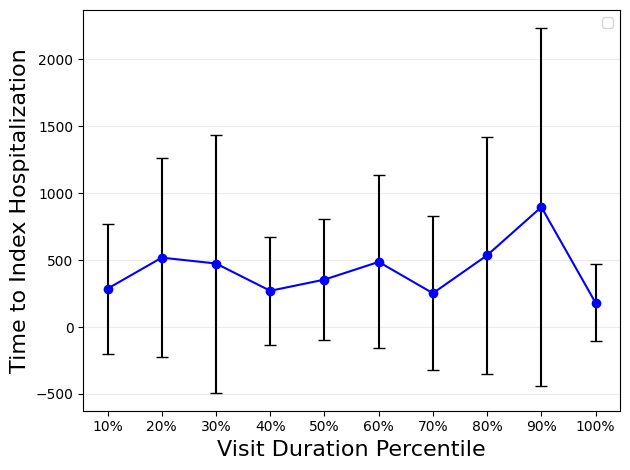

Person: PearsonRResult(statistic=-0.014937070530096852, pvalue=0.7469693583712349)
Spearman: SignificanceResult(statistic=0.022740583377782096, pvalue=0.6232647124220179)


In [ ]:
visits_df_kids = next_visit_df.dropna(subset=["stay_duration"])
visits_df_kids["stay_duration_group"] = pd.qcut(visits_df_kids['stay_duration'], q = 10, labels = False)  
print("stay_duration_group")
print_differances_next_visit(visits_df_kids, 'stay_duration_group', True)

    

print("Person: {}".format(pearsonr(visits_df_kids['stay_duration'], visits_df_kids['next_time_visit'])))
print("Spearman: {}".format(spearmanr(visits_df_kids['stay_duration'], visits_df_kids['next_time_visit'])))

